In [1]:
import math
import random
import skimage.io as io
import matplotlib.pyplot as plt
import keras
import pickle
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import sys
# import skvideo.io
import json
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import glob
import re
from collections import defaultdict

import nltk
from nltk.corpus import cmudict
import tensorflow as tf
import wer

/n/fs/daps/anaconda2/envs/conda-audio-3.6/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/n/fs/daps/anaconda2/envs/conda-audio-3.6/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/n/fs/daps/anaconda2/envs/conda-audio-3.6/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/n/fs/daps/anaconda2/envs/conda-audio-3.6/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy

In [ ]:
!nvidia-smi

In [3]:
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [4]:
phoneme_list = [] 
phoneme_dict = {}

with open("/n/fs/scratch/jiaqis/cmudict-master/cmudict.phones", 'r') as fp:
    i = 0
    line = fp.readline()
    while line:
        phoneme = line.split()[0].strip()
        phoneme_property = line.split()[1].strip()
        phoneme_list.append((phoneme, phoneme_property))
        phoneme_dict[phoneme] = i+3
        line = fp.readline()
        i=i+1
        
phoneme_dict['START'] = 0
phoneme_dict["END"] = 1
phoneme_dict["UNK"] = 2
print(phoneme_list, phoneme_dict)

([('AA', 'vowel'), ('AE', 'vowel'), ('AH', 'vowel'), ('AO', 'vowel'), ('AW', 'vowel'), ('AY', 'vowel'), ('B', 'stop'), ('CH', 'affricate'), ('D', 'stop'), ('DH', 'fricative'), ('EH', 'vowel'), ('ER', 'vowel'), ('EY', 'vowel'), ('F', 'fricative'), ('G', 'stop'), ('HH', 'aspirate'), ('IH', 'vowel'), ('IY', 'vowel'), ('JH', 'affricate'), ('K', 'stop'), ('L', 'liquid'), ('M', 'nasal'), ('N', 'nasal'), ('NG', 'nasal'), ('OW', 'vowel'), ('OY', 'vowel'), ('P', 'stop'), ('R', 'liquid'), ('S', 'fricative'), ('SH', 'fricative'), ('T', 'stop'), ('TH', 'fricative'), ('UH', 'vowel'), ('UW', 'vowel'), ('V', 'fricative'), ('W', 'semivowel'), ('Y', 'semivowel'), ('Z', 'fricative'), ('ZH', 'fricative')], {'IY': 20, 'START': 0, 'W': 38, 'DH': 12, 'Y': 39, 'HH': 18, 'CH': 10, 'JH': 21, 'ZH': 41, 'END': 1, 'EH': 13, 'UNK': 2, 'NG': 26, 'TH': 34, 'AA': 3, 'B': 9, 'AE': 4, 'D': 11, 'G': 17, 'F': 16, 'AH': 5, 'K': 22, 'M': 24, 'L': 23, 'AO': 6, 'N': 25, 'IH': 19, 'S': 31, 'R': 30, 'EY': 15, 'T': 33, 'AW': 7,

In [5]:
pron_dict = cmudict.dict()

In [6]:
DATA_DIR = "/n/fs/scratch/jiaqis/LRS3-TED/"
SAVE_DIR = "/n/fs/scratch/jiaqis/LRS3-TED-Extracted/"

In [7]:
test_ID_list = json.load(open('test_ID_list.json', "r"))
trainval_ID_list = json.load(open('trainval_ID_list.json', "r"))

In [8]:
import logging

import numpy as np
import tensorflow as tf
from tensorflow.contrib import layers


GO_TOKEN = 0
END_TOKEN = 1
UNK_TOKEN = 2

In [9]:
def clean_pron(pron):
    """Remove stress from pronunciations."""
    return re.sub(r"\d", "", pron)

def make_triphones(pron):
    """Output triphones from a word's pronunciation."""
    if len(pron) < 3:
        return []
    # Junk on end is to make word boundaries work
    return ([((pron[idx - 2], pron[idx - 1]), pron[idx])
             for idx in range(2, len(pron))] + [(('#', '#'), pron[0])] +
            [((pron[-2], pron[-1]), '#')])
                                                
def triphone_probs(prons):
    """Calculate triphone probabilities for pronunciations."""
    context_counts = defaultdict(lambda: defaultdict(int))
    for pron in prons:
        for (context, phoneme) in make_triphones(pron):
            context_counts[context][phoneme] += 1
            
    for (context, outcomes) in context_counts.items():
        total_outcomes = sum(outcomes.values())
        for outcome, count in outcomes.items():
            context_counts[context][outcome] = float(count) / total_outcomes
        
    return context_counts

In [10]:
def prepare_data(filepath, img_size, keypoint_img_size, keypoint_size):
    # images
    # frames x rows x cols x channels
    visual_cube = []
    # keypoint features
    feature_cube = []
    features = json.load(open(filepath + ".json", 'r'))
    # Target Text/phonemes
    labels = []
    text = open(filepath+".txt", 'r').readline()
    words = text[5:].lower().strip().split()
    for word in words:
        word_phonemes = pron_dict[word][0]
        word_indices = [phoneme_dict[clean_pron(phon)] for phon in word_phonemes]
        labels.extend(word_indices)
        
    acc = 0
    for imgFilename in sorted(glob.glob(filepath + "_*_mouth.jpg")): # 
#         if 'mouth' in imgFilename: # 
#             continue               #
        x = image.img_to_array(
              image.load_img(imgFilename, target_size=img_size))/255.0
#         x = np.expand_dims(x, axis=0)
#         x = preprocess_input(x)
        visual_cube.append(x)
        
        mask = np.zeros((keypoint_img_size[0], keypoint_img_size[1], keypoint_size))
        framenum = str(int(imgFilename.split("_")[-2].split(".")[0])) # 
        f_feature = features[framenum]['mouthCoords']
        for ft_index in range(keypoint_size):
            # TODO: check range of outputs
            keypoint_x = min(f_feature[ft_index][0] - 1, 223)
            keypoint_y = min(f_feature[ft_index][1] - 1, 223)
            mask[keypoint_y, keypoint_x, ft_index] = 1.0
        feature_cube.append(mask)
        acc+=1
    return np.array(visual_cube), np.array(feature_cube), labels

In [11]:
def frame_wise_op(inputs, operation, **kwargs):
    # batch x timesteps x w x h x c
    # or
    # batch x timesteps x c
    inputs_flat = tf.reshape(inputs, tf.concat([tf.constant(-1, shape=(1,)), 
                                                tf.shape(inputs)[2:]], axis=0))
    print(inputs, inputs_flat)
    outputs_flat = operation(inputs_flat, **kwargs)

    output_shape = tf.concat([tf.shape(inputs)[:2], tf.shape(outputs_flat)[1:]], 0)
    outputs = tf.reshape(outputs_flat, output_shape)

    return outputs

In [60]:
def seq2seq(mode, features, labels, params):
    is_training = True
    
    vocab_size = params['vocab_size']
    embed_dim = params['embed_dim']
    num_units = params['num_units']
    input_max_length = params['input_max_length']
    output_max_length = params['output_max_length']

    inp = features['input']
    output = features['output']
    batch_size = tf.shape(inp)[0]
    start_tokens = tf.zeros([batch_size], dtype=tf.int64)
    print(inp, start_tokens)
    train_output = tf.concat([tf.expand_dims(start_tokens, 1), output], 1)
    # b x f x w x h x c
    input_lengths = tf.reduce_sum(tf.to_int32(tf.reduce_sum(tf.to_int32(tf.not_equal(inp, 0.0)), 
                                                            axis=(2,3,4))>0), 1)
    # b x seq
    output_lengths = tf.reduce_sum(tf.to_int32(tf.not_equal(train_output, END_TOKEN)), 1)
    print(train_output, input_lengths, output_lengths, output)

    with tf.variable_scope('video_embed', reuse=tf.AUTO_REUSE):
        # 224 x 224 x 64
        conv1 = frame_wise_op(inp,
                     operation=tf.layers.conv2d,
                     filters=64,
                     kernel_size=[3, 3],
                     padding='same')
        conv1 = tf.layers.batch_normalization(
                    conv1,
                    axis=-1,
                    training=is_training,
                    trainable=True
                )
        conv1 = tf.nn.relu(conv1)

        # 112 x 112 x 64
        down1 = frame_wise_op(conv1,
                            operation=tf.layers.max_pooling2d,
                            pool_size=[2, 2],
                            strides=2)
        # 112 x 112 x 128
        conv2 = frame_wise_op(down1,
                     operation=tf.layers.conv2d,
                     filters=128,
                     kernel_size=[3, 3],
                     padding='same',)
        conv2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            training=is_training,
            trainable=True
        )
        conv2 = tf.nn.relu(conv2)
        
        # 56 x 56 x 128
        down2 = frame_wise_op(conv2,
                            operation=tf.layers.max_pooling2d,
                            pool_size=[2, 2],
                            strides=2)
        # 56 x 56 x 256
        conv3 = frame_wise_op(down2,
                     operation=tf.layers.conv2d,
                     filters=256,
                     kernel_size=[3, 3],
                     padding='same')
        conv3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            training=is_training,
            trainable=True
        )
        conv3 = tf.nn.relu(conv3)
        
        # 28 x 28 x 256
        down3 = frame_wise_op(conv3,
                            operation=tf.layers.max_pooling2d,
                            pool_size=[2, 2],
                            strides=2)
        # 28 x 28 x 256
        conv4 = frame_wise_op(down3,
                     operation=tf.layers.conv2d,
                     filters=256,
                     kernel_size=[3, 3],
                     padding='same')
        conv4 = tf.layers.batch_normalization(
            conv4,
            axis=-1,
            training=is_training,
            trainable=True
        )
        conv4 = tf.nn.relu(conv4)
        
        # 14 x 14 x 256
        down4 = frame_wise_op(conv4,
                            operation=tf.layers.max_pooling2d,
                            pool_size=[2, 2],
                            strides=2)
        # 14 x 14 x 256
        conv5 = frame_wise_op(down4,
                     operation=tf.layers.conv2d,
                     filters=256,
                     kernel_size=[3, 3],
                     padding='same')
        conv5 = tf.layers.batch_normalization(
            conv5,
            axis=-1,
            training=is_training,
            trainable=True
        )
        conv5 = tf.nn.relu(conv5)
        # 7 x 7 x 256
        down5 = frame_wise_op(conv5,
                            operation=tf.layers.max_pooling2d,
                            pool_size=[2, 2],
                            strides=2)
        # 256
        down5_shape =down5.shape.as_list()
        flattened = frame_wise_op(down5, 
                           operation=tf.reshape,
                           shape=(-1, down5_shape[-1]*down5_shape[-2]*down5_shape[-3]))
        fc6 = frame_wise_op(flattened, 
                           operation=tf.layers.dense,
                           units=256,
                           activation='relu')
    
    output_embed = layers.embed_sequence(
        train_output, vocab_size=vocab_size, embed_dim=embed_dim, scope='embed')
    with tf.variable_scope('embed', reuse=True):
        embeddings = tf.get_variable('embeddings', dtype=tf.float32)

    cell = tf.contrib.rnn.GRUCell(num_units=num_units)
    encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(cell, fc6, dtype=tf.float32)
    print(encoder_outputs, encoder_final_state)
    
    tiled_context_vector = tf.tile(tf.reshape(encoder_final_state, (-1, 1, 256)),
                                       multiples=[1,tf.shape(output_embed)[1],1]
                                      )
    print(embeddings, tiled_context_vector)
    
#     def re_embed(x):
#         indices = tf.argmax(x, axis=-1)
#         return tf.nn.embedding_lookup(embeddings, indices)
    
    train_helper = tf.contrib.seq2seq.TrainingHelper(output_embed, output_lengths)
#     train_helper = tf.contrib.seq2seq.ScheduledOutputTrainingHelper(
#         inputs = output_embed,
#         sequence_length = output_lengths,
#         next_inputs_fn = re_embed,
#         auxiliary_inputs = tiled_context_vector, # condtional on inputs
#         sampling_probability = 0.0, # for fullly inference
#     )
#     train_helper = tf.contrib.seq2seq.ScheduledEmbeddingTrainingHelper(
#         output_embed, output_lengths, embeddings, 1.0
#     )
    
#     def re_embed_inference(outputs):
#         sample_ids = tf.argmax(x, axis=-1)
#         finished = tf.equal(sample_ids, END_TOKEN)
#         all_finished = tf.reduce_all(finished)
#         next_inputs = tf.cond(
#             all_finished,
#             # If we're finished, the next_inputs value doesn't matter
#             lambda: tf.nn.embedding_lookup(embeddings, start_tokens),
#             lambda: tf.nn.embedding_lookup(embeddings, sample_ids))
#         print("next_inputs:", next_inputs)
#         return tf.concat([tf.to_float32(next_inputs), encoder_final_state], axis=-1)
    
    pred_helper = tf.contrib.seq2seq.SampleEmbeddingHelper(
        embeddings,
        start_tokens=tf.to_int32(start_tokens), end_token=1,
    )
#     pred_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
#                         embeddings, start_tokens=tf.to_int32(start_tokens), end_token=1)
#     pred_helper =tf.contrib.seq2seq.InferenceHelper(
#                             sample_fn = (lambda outputs: outputs),
#                             sample_shape = tf.TensorShape([vocab_size]),
#                             sample_dtype = tf.float32,
#                             start_inputs = tf.nn.embedding_lookup(embeddings, start_tokens),
#                             end_fn = (lambda x: tf.argmax(x, axis=-1)==END_TOKEN),
#                             next_inputs_fn = re_embed_inference,
#                         )
    print("here")
    
    def decode(helper, scope, reuse=None):
        with tf.variable_scope(scope, reuse=reuse):
            attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
                num_units=num_units, memory=encoder_outputs,
                memory_sequence_length=input_lengths)
            cell = tf.contrib.rnn.GRUCell(num_units=num_units)
            attn_cell = tf.contrib.seq2seq.AttentionWrapper(
                cell, attention_mechanism, attention_layer_size=num_units / 2)
            out_cell = tf.contrib.rnn.OutputProjectionWrapper(
                attn_cell, vocab_size, reuse=reuse
            )
            decoder_initial_state = out_cell.zero_state(
                                        dtype=tf.float32, batch_size=batch_size)
            decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_final_state)
            
#             dec_out_dense = Dense(units = num_units,
#                       activation = ''
#                      )
            decoder = tf.contrib.seq2seq.BasicDecoder(
                cell=out_cell, helper=helper,
                initial_state=decoder_initial_state)
#                 initial_state=encoder_final_state)
            outputs = tf.contrib.seq2seq.dynamic_decode(
                decoder=decoder, output_time_major=False,
                impute_finished=True, maximum_iterations=output_max_length
            )
            return outputs[0]
    train_outputs = decode(train_helper, 'decode')
    print(train_outputs, train_outputs.rnn_output)
    
    pred_outputs = decode(pred_helper, 'decode', reuse=True)

    tf.identity(train_outputs.sample_id[0], name='train_pred')
    weights = tf.to_float(tf.not_equal(train_output[:, :-1], 1))
    loss = tf.contrib.seq2seq.sequence_loss(
        train_outputs.rnn_output, output, weights=weights)
    train_op = layers.optimize_loss(
        loss, tf.train.get_global_step(),
        optimizer=params.get('optimizer', 'Adam'),
        learning_rate=params.get('learning_rate', 0.001),
        learning_rate_decay_fn = (lambda p1, p2: tf.train.exponential_decay(
                                                        p1,
                                                        p2,
                                                        10000,
                                                        0.6,
                                                        staircase=False,
                                                    )),
        summaries=['loss', 'learning_rate'])

    tf.identity(pred_outputs.sample_id[0], name='predictions')
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={'train_pred':train_outputs.sample_id, 'predictions':pred_outputs.sample_id},
        loss=loss,
        train_op=train_op
    )

In [61]:
def tokenize_and_map(line, vocab):
    return [vocab.get(token, UNK_TOKEN) for token in line.split(' ')]

def make_input_fn(
        data_dir, subset, list_IDs, prons, phonemes,
        input_max_length, output_max_length,
        img_size, keypoint_img_size,
        keypoint_size,
        batch_size=1,
        input_process=tokenize_and_map, 
        output_process=tokenize_and_map):

    def input_fn():
        inp = tf.placeholder(tf.float32, shape=[None, None, img_size[0], img_size[1], img_size[2]], name='input')
        output = tf.placeholder(tf.int64, shape=[None, None], name='output')
        tf.identity(inp[0], 'input_0')
        tf.identity(output[0], 'output_0')
        return {
            'input': inp,
            'output': output,
        }, None

    def sampler():
        while True:
            rnd = random.randint(0, len(list_IDs)-1)
            v_ID = list_IDs[rnd]
            v_url, v_index = v_ID
            filepath = os.path.join(data_dir, subset, v_url, v_index)
            v_V, v_F, v_T = prepare_data(filepath, img_size, keypoint_img_size,
                                           keypoint_size)
            num_frames = v_V.shape[0]
            yield {
                    'input':  v_V[:min(num_frames,input_max_length), :, :, :], # v_F[:input_max_length]),
                    'output': v_T[:output_max_length - 1] + [END_TOKEN]
                }

    sample_me = sampler()

    def feed_fn():
        inputs, outputs = [], []
        input_length, output_length = 0, 0
        for i in range(batch_size):
            rec = sample_me.next()
            inputs.append(rec['input'])
            outputs.append(rec['output'])
            num_frames = inputs[-1].shape[0] #
#             print(inputs[-1].shape)
            input_length = max(input_length, num_frames)
            output_length = max(output_length, len(outputs[-1]))
        # Pad me right with </S> token.
        for i in range(batch_size):
            num_frames = inputs[i].shape[0]
            if input_length>num_frames:
                new_input_V = np.pad(inputs[i], [(input_length - num_frames, 0), (0,0), (0,0), (0,0)], 'constant')
                # new_input_F = np.pad(inputs[i][1], [output_length - num_frames, 0, 0, 0], 'constant')
                inputs[i] = new_input_V
            outputs[i] += [END_TOKEN] * (output_length - len(outputs[i]))
        return {
            'input:0': inputs,
            'output:0': outputs
        }

    return input_fn, feed_fn


def get_rev_vocab(vocab):
    return {idx: key for key, idx in vocab.iteritems()}

def get_formatter(keys, vocab):
    rev_vocab = get_rev_vocab(vocab)
    def to_str(sequence):
        tokens = [
            rev_vocab.get(x, "<UNK>") for x in sequence]
        return ' '.join(tokens)

    def format(values):
        res = []
        for key in keys:
            res.append("%s = %s" % (key, to_str(values[key])))
        return '\n'.join(res)
    return format

def get_editdist_formatter(keys, vocab):
    rev_vocab = get_rev_vocab(vocab)
    
    def to_str(sequence):
        tokens = [
            rev_vocab.get(x, "<UNK>") for x in sequence]
        return tokens

    def format(values):
        labels = values[keys[0]]  
        clean_labels = []
        for label in labels:
            if label == END_TOKEN:
                break
            else:
                clean_labels.append(label)
        clean_labels = to_str(clean_labels)
        
        preds =  values[keys[1]]
        clean_preds = []
        for pred in preds:
            if pred == END_TOKEN:
                break
            else:
                clean_preds.append(pred)
        clean_preds = to_str(clean_preds)
        wer.wer(clean_labels, clean_preds)
        return '\n====== WER '+ keys[1]+' ======\n'
    
    return format

In [62]:
def train_seq2seq(data_dir, subset, model_dir, list_IDs, prons, phonemes):
    params = {
        'vocab_size': 42,
        'batch_size': 8,
        'input_max_length': 100,
        'output_max_length': 100,
        'embed_dim': 100,
        'num_units': 256,
        'img_size': (120, 120, 3), 
        'keypoint_img_size': (224, 224),
        'keypoint_size': 20,
        'n_classes':39,
        'num_tokens': 42
    }
    est = tf.estimator.Estimator(
        model_fn=seq2seq,
        model_dir=model_dir, params=params)

    input_fn, feed_fn = make_input_fn(
                            data_dir, subset, list_IDs, prons, phonemes,
                            params['input_max_length'], params['output_max_length'],
                            params['img_size'], params['keypoint_img_size'],
                            params['keypoint_size'],
                            params['batch_size'])

    # Make hooks to print examples of inputs/predictions.
    print_inputs = tf.train.LoggingTensorHook(
        ['output_0'], every_n_iter=100,
        formatter=get_formatter(['output_0'], phonemes))
    print_predictions = tf.train.LoggingTensorHook(
        ['predictions', 'train_pred'], every_n_iter=100,
        formatter=get_formatter(['predictions', 'train_pred'], phonemes))
    print_train_edit_distance = tf.train.LoggingTensorHook(
        ['output_0', 'train_pred'], every_n_iter=100,
        formatter=get_editdist_formatter(['output_0', 'train_pred'], phonemes))
    print_pred_edit_distance = tf.train.LoggingTensorHook(
        ['output_0', 'predictions'], every_n_iter=100,
        formatter=get_editdist_formatter(['output_0', 'predictions'], phonemes))

    est.train(
        input_fn=input_fn,
        hooks=[tf.train.FeedFnHook(feed_fn), print_inputs, print_predictions, 
                       print_train_edit_distance, print_pred_edit_distance],
        steps=100000)

In [ ]:
#     tf.logging.logger.setLevel(logging.INFO)
train_seq2seq(SAVE_DIR, 'trainval', './model/seq2seq_copiedstates_bn', trainval_ID_list, pron_dict, phoneme_dict)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff5835faf90>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './model/seq2seq_copiedstates_bn', '_train_distribute': None, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
(<tf.Tensor 'input:0' shape=(?, ?, 120, 120, 3) dtype=float32>, <tf.Tensor 'zeros:0' shape=(?,) dtype=int64>)
(<tf.Tensor 'concat:0' shape=(?, ?) dtype=int64>, <tf.Tensor 'Sum_1:0' shape=(?,) dtype=int32>, <tf.Tensor 'Sum_2:0' shape=(?,) dtype=int32>, <tf.Tensor 'output:

INFO:tensorflow:loss = 1.3787992, step = 57072 (414.005 sec)
INFO:tensorflow:Saving checkpoints for 57114 into ./model/seq2seq_copiedstates_bn/model.ckpt.
INFO:tensorflow:global_step/sec: 0.243637
INFO:tensorflow:output_0 = DH EY N OW DH AE T END END END END END END END END END END END END END END END END END END END
INFO:tensorflow:predictions = W IY HH AE V T UW TH IH NG K AH V IH T END START START START START START START START START START START START START START START START
train_pred = AY AE D OW DH AE T DH START START START START START START START START START START START START START START START START START START
REF: DH EY N OW DH AE T                                                                                                               
HYP: AY AE D OW DH AE T DH START START START START START START START START START START START START START START START START START START
EVA: S  S  S            I  I     I     I     I     I     I     I     I     I     I     I     I     I     

REF: AH N D HH IY W AA Z AO F   AH N IH N DH AH AH DH ER R UW M        
HYP: DH N D DH IY S AA Z    F R AH N AY N DH AH AH DH ER W AY M Z START
EVA: S      S     S      D    I      S                   S S    I I    
WER: 45.45%
INFO:tensorflow:
====== WER train_pred ======

REF: AH N D HH IY W  AA Z AO F  AH N IH N  DH AH AH DH ER R UW M
HYP:              DH AE T S  DH AH N    AY M  AA S  M  AY F AE M
EVA: D  D D D  D  S  S  S S  S       D  S  S  S  S  S  S  S S   
WER: 86.36%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.2154641, step = 57972 (397.829 sec)
INFO:tensorflow:Saving checkpoints for 58009 into ./model/seq2seq_copiedstates_bn/model.ckpt.
INFO:tensorflow:global_step/sec: 0.243868
INFO:tensorflow:output_0 = DH AE T K R EY Z IY W UH M AH N END END END END END END END END END END
INFO:tensorflow:predictions = DH AE T S HH AW AY TH IH NG K W AY END START START START START START START START START START START START START START
train_pred = AY AE T S W AE

INFO:tensorflow:loss = 0.99523216, step = 58772 (441.360 sec)
INFO:tensorflow:global_step/sec: 0.221594
INFO:tensorflow:output_0 = Y UW V B AA T IH N T UW IH T END END END END END END END END END END END END END END END
INFO:tensorflow:predictions = F AO R IH M P AW ER F AH L END START START START START START START START START START START START START START START
train_pred = W UW N G IH T IH N T UW DH T END START START START START START START START START START START START START START START
REF: Y UW V B AA T IH N T UW IH T
HYP: W UW N G IH T IH N T UW DH T
EVA: S    S S S              S   
WER: 41.67%
INFO:tensorflow:
====== WER train_pred ======

REF: Y UW V  B AA T IH N  T  UW IH T
HYP:   F  AO R IH M P  AW ER F  AH L
EVA: D S  S  S S  S S  S  S  S  S  S
WER: 100.00%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.2972283, step = 58872 (451.277 sec)
INFO:tensorflow:Saving checkpoints for 58879 into ./model/seq2seq_copiedstates_bn/model.ckpt.
INFO:tensorflow:g

REF: AH N D DH OW Z  IH N S AY T S K AE N  B IY Y UH R  Z 
HYP:        DH    EH R  N   AA T     JH AH S T  S EY IH NG
EVA: D  D D    D  S  S    D S    D D S  S  S S  S S  S  S 
WER: 85.71%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.1736554, step = 59672 (349.623 sec)
INFO:tensorflow:Saving checkpoints for 59709 into ./model/seq2seq_copiedstates_bn/model.ckpt.
INFO:tensorflow:global_step/sec: 0.296145
INFO:tensorflow:output_0 = AY M DH AH N AH M B ER W AH N END END END END END END END END END END END END END END END END END
INFO:tensorflow:predictions = AY AE S K T DH AH K L UW M END START START START START START START START START START START START START START START START START START
train_pred = AY W G AH S EH M B ER W AH N END START START START START START START START START START START START START START START START START
REF: AY M DH AH N AH M B ER W AH N
HYP: AY W G  AH S EH M B ER W AH N
EVA:    S S     S S               
WER: 33.33%
INFO:tensorflow:
==

REF: AY W EH N T T  UW S AH DH ER N AE F  R AH K  AH       
HYP:      AH V K AO R  S    DH IY Z G  IH V IH NG AH B AA T
EVA: D  D S  S S S  S    D     S  S S  S  S S  S     I I  I
WER: 100.00%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.1128432, step = 60572 (335.717 sec)
INFO:tensorflow:Saving checkpoints for 60603 into ./model/seq2seq_copiedstates_bn/model.ckpt.
INFO:tensorflow:global_step/sec: 0.295092
INFO:tensorflow:output_0 = W IY AA R N AA T DH EH R T UW S T EY END END END END END END END END END END
INFO:tensorflow:predictions = S OW AY F AA L OW N ER AW N D DH AE T END START START START START START START START START START START START START START START START
train_pred = DH IY HH R G AA T S AH R S UW S T EY END START START START START START START START START START
REF: W  IY AA R N AA T DH EH R T UW S T EY
HYP: DH IY HH R G AA T S  AH R S UW S T EY
EVA: S     S    S      S  S    S          
WER: 40.00%
INFO:tensorflow:
====== WER train_pred ======



REF: K AE N W IY F AY N D DH AE T  L  AE NG G W AH JH  
HYP:                      DH    EY HH AE V  D R IY M  Z
EVA: D D  D D D  D D  D D    D  S  S     S  S S S  S  I
WER: 94.74%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.2079794, step = 61472 (363.411 sec)
INFO:tensorflow:Saving checkpoints for 61555 into ./model/seq2seq_copiedstates_bn/model.ckpt.
INFO:tensorflow:global_step/sec: 0.205077
INFO:tensorflow:output_0 = B AH T IH T S AH B AW T N AH M B ER Z END END END END END END END END END END END END
INFO:tensorflow:predictions = B AH T IH T F IH R T ER N AW END START START START START START START START START START START START START START START START START START START START
train_pred = W AH T W T S N N AW T W OW M B ER Z END START START START START START START START START START START START
REF: B AH T IH T S AH B AW T N AH M B ER Z
HYP: W AH T W  T S N  N AW T W OW M B ER Z
EVA: S      S      S  S      S S          
WER: 37.50%
INFO:tensorflow:
====== W

REF: B  AY DH AH W EY IH T IH Z DH AH S EY M F AO R AO L AH V AH S
HYP: AH AH DH AH W EY W  T IH Z AH AH S EY M D AO R DH L AH V AH S
EVA: S  S             S         S            S      S             
WER: 25.00%
INFO:tensorflow:
====== WER train_pred ======

REF: B AY           DH AH W EY IH T IH Z DH AH      S EY M  F  AO R    AO L AH V  AH S 
HYP: R IH L IY IH N DH AH B AA D  R IH F AO R  G AE S K  IH NG T  UW Y AO R M  AE N  IY
EVA: S S  I I  I  I       S S  S  S    S S  S  I I    S  S  S  S  S  I    S S  S  S  S 
WER: 108.33%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.0494896, step = 62372 (410.939 sec)
INFO:tensorflow:Saving checkpoints for 62387 into ./model/seq2seq_copiedstates_bn/model.ckpt.
INFO:tensorflow:global_step/sec: 0.246968
INFO:tensorflow:output_0 = S OW EH V ER IY F AY V M IH N AH T S AY T UH K AH F OW T AH G R AE F END END
INFO:tensorflow:predictions = DH EH R IH Z B IY P R EH P AH N END START START START START START START START START 

REF: DH EY W ER HH OW P IH NG AH N D  P R EY IH NG
HYP:    AH N D  AH S  T AO R  IY W AH T R    AY T 
EVA: D  S  S S  S  S  S S  S  S  S S  S   D  S  S 
WER: 94.12%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.1992017, step = 63172 (348.862 sec)
INFO:tensorflow:global_step/sec: 0.290522
INFO:tensorflow:output_0 = W IY AO L S T AA R T AH D AE Z N AA V AH S IH Z END END
INFO:tensorflow:predictions = W IY L UH K L AE S T AO R IY W EH R W AA Z IH T END START START START START START
train_pred = DH IY HH L N OW AE R T AH D END Z K OW T AH S END K END START
REF: W  IY AO L S T  AA R T AH D AE Z N AA V AH S IH Z
HYP: DH IY HH L N OW AE R T AH D                      
EVA: S     S    S S  S           D  D D D  D D  D D  D
WER: 70.00%
INFO:tensorflow:
====== WER train_pred ======

REF: W IY AO      L    S T AA R T AH D AE Z N AA V AH S IH Z
HYP: W IY L  UH K L AE S T AO R   IY W EH R W AA      Z IH T
EVA:      S  I  I   I      S    D S  S S  S S    D D  S    S
WER: 75

REF: W  EH R  D IH D IH T G OW R AO NG
HYP: AY L  AH V AE D AH T           IY
EVA: S  S  S  S S    S    D D  D D  S 
WER: 84.62%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.1076661, step = 64072 (406.733 sec)
INFO:tensorflow:Saving checkpoints for 64147 into ./model/seq2seq_copiedstates_bn/model.ckpt.
INFO:tensorflow:global_step/sec: 0.245792
INFO:tensorflow:output_0 = M AY M AH DH ER HH AE D AH F IH T END END END END END END END END END END END END END END END
INFO:tensorflow:predictions = UH D Y UW N OW IH T UW M Y UW N OW TH IH NG END START START START START START START START START
train_pred = W EY F AH DH ER Z AE D AH K IH T END START START START START START START START START START START START START START START
REF: M AY M AH DH ER HH AE D AH F IH T
HYP: W EY F AH DH ER Z  AE D AH K IH T
EVA: S S  S          S          S     
WER: 38.46%
INFO:tensorflow:
====== WER train_pred ======

REF: M  AY M AH DH ER HH AE D  AH F            IH T 
HYP: UH D  Y UW 

INFO:tensorflow:predictions = W IH CH W AY IH N DH AH K AA N V ER D END START START START START START START START START START START START START
train_pred = AY T S AA Z AH OW N P L IY S IH S END START START START START START START START START START START START START START START START START START START START
REF: IH T W AA Z S  IH M P L IY DH IH S
HYP: AY T S AA Z AH OW N P L IY S  IH S
EVA: S    S      S  S  S        S      
WER: 42.86%
INFO:tensorflow:
====== WER train_pred ======

REF:   IH T  W AA Z  S IH M  P L  IY DH IH S
HYP: W IH CH W AY IH N DH AH K AA N  V  ER D
EVA: I    S    S  S  S S  S  S S  S  S  S  S
WER: 92.86%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 0.96018505, step = 65072 (367.326 sec)
INFO:tensorflow:Saving checkpoints for 65145 into ./model/seq2seq_copiedstates_bn/model.ckpt.
INFO:tensorflow:global_step/sec: 0.307598
INFO:tensorflow:output_0 = DH AH HH AH M IH Z M Y UW Z IH K END END END END END END END END END END END END END END END

REF: DH EH R Z  S OW M AH CH IH N  F ER M EY SH AH N AW    T DH EH R    
HYP:         AY S               EH D G  R AE B  AH L IY IH T S  W  ER IY
EVA: D  D  D S    D  D D  D  D  S  S S  S S  S     S S  I    S  S  S  I 
WER: 95.65%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.1622096, step = 65872 (272.050 sec)
INFO:tensorflow:global_step/sec: 0.420126
INFO:tensorflow:output_0 = W IY M IY T AE T DH AH P AH B END END END END END END END END END END END END END END END END END END END END END END
INFO:tensorflow:predictions = AY W AA Z IH N D UW HH OW L D END START START START START START START START START START START START START START START START START
train_pred = DH IY N EY T S T DH AH P AH B END START START START START START START START START START START START START START START START START START START START START START
REF: W  IY M IY T AE T DH AH P AH B
HYP: DH IY N EY T S  T DH AH P AH B
EVA: S     S S    S                
WER: 33.33%
INFO:tensorflow:
===

REF: DH AE T S W  AY Y UW S IY IH T IH N EH V ER IY S UW P ER M  AA R  K  IH T
HYP:         S OW AY                        M HH IY R OW P    AH N  AE SH AH N
EVA: D  D  D   S     D D  D D  D  D D  D D  S S     S S    D  S  S  S  S  S  S
WER: 85.71%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.2859867, step = 66772 (257.535 sec)
INFO:tensorflow:global_step/sec: 0.361048
INFO:tensorflow:output_0 = W AY HH AE V AH N T Y UW T EY K AH N AH SH AW ER END END END END END
INFO:tensorflow:predictions = B AH T HH AW D UW W IY IH K S DH AE T IH T S K EY N S END START
train_pred = W IY D AE V AH N T W UW T UW K AH N AH DH AW ER END START START START START
REF: W AY HH AE V AH N T Y UW T EY K AH N AH SH AW ER
HYP: W IY D  AE V AH N T W UW T UW K AH N AH DH AW ER
EVA:   S  S              S      S            S       
WER: 26.32%
INFO:tensorflow:
====== WER train_pred ======

REF: W AY   HH AE V AH N T  Y  UW T EY K  AH N  AH SH AW ER    
HYP: B AH T HH AW D UW W IY IH K  S 

REF: AY W  IH SH AY           K UH D  F                   L AY              
HYP: Y  UW HH AE V  T UW T EH K T  DH EH M T UW AE K K EY L V  IH S K AO R M
EVA: S  S  S  S  S  I I  I I    S  S  S  I I I  I  I I I    S  I  I I I  I I
WER: 236.36%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.0459818, step = 67672 (255.761 sec)
INFO:tensorflow:global_step/sec: 0.404757
INFO:tensorflow:output_0 = W IY W AA N T DH AE T IH K S P IH R IY AH N S END END END END END
INFO:tensorflow:predictions = DH AH K W EH S CH AH N HH AE Z IY T UW D UW END START START START START START START START START START START START START START
train_pred = AY IY HH ER N T AH AE T IH K S P IH R IY AH N S END START START START START
REF: W  IY W  AA N T DH AE T IH K S P IH R IY AH N S
HYP: AY IY HH ER N T AH AE T IH K S P IH R IY AH N S
EVA: S     S  S      S                              
WER: 21.05%
INFO:tensorflow:
====== WER train_pred ======

REF: W IY W AA N  T DH AE T IH K  S P  IH R IY AH

REF: S  AH M W  AH N IH Z M EY K IH NG DH AH R UW L Z
HYP: DH OW M AH AH N M  Z M EY K IH NG DH AH R UW L Z
EVA: S  S    S       S                               
WER: 21.05%
INFO:tensorflow:
====== WER train_pred ======

REF: S  AH M  W AH N IH Z  M EY K  IH NG DH AH R UW L  Z      
HYP: IY P  IY P AH L R  EH S T  TH IH NG    AH L W  IH DH M IY
EVA: S  S  S  S    S S  S  S S  S        D     S S  S  S  I I 
WER: 89.47%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.0815314, step = 68572 (253.117 sec)
INFO:tensorflow:global_step/sec: 0.354487
INFO:tensorflow:output_0 = IH T S IH N Y AO R S UW P END END END END END END END END END END END END END END END
INFO:tensorflow:predictions = AY W AA N T AH D T UW AO L G OW IH NG T AH D EY END START START START
train_pred = DH T S N N Y AO R S EH P END START START START START START START START START START START START START START START
REF: IH T S IH N Y AO R S UW P
HYP: DH T S N  N Y AO R S EH P
EVA: S      S             

REF: L AA T S AH V AE N  AH M AH L P R AA D    AH K T  S     
HYP:          AH N D  DH IH S IH Z P R IH T IY AH M UW P L EY
EVA: D D  D D    S S  S  S  S S  S     S  S I     S S  S I I 
WER: 95.00%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 0.890661, step = 69472 (265.821 sec)
INFO:tensorflow:global_step/sec: 0.367022
INFO:tensorflow:output_0 = DH AE T S AH S AH T AH L P OY N T END END END END END END END
INFO:tensorflow:predictions = DH AE T S N EH K S T AH F EH R AH K AH N END START START START START START START START START START START START START START START START START START START START
train_pred = W AE T S W P T T AH L B OY N T END START START START START START START
REF: DH AE T S AH S AH T AH L P OY N T
HYP: W  AE T S W  P T  T AH L B OY N T
EVA: S         S  S S         S       
WER: 35.71%
INFO:tensorflow:
====== WER train_pred ======

REF: DH AE T S AH S  AH   T AH L P  OY N  T     
HYP: DH AE T S N  EH K  S T AH F EH R  AH K AH N
EVA:           S

REF: W AY D IH D HH IY D AY
HYP: W IY D UW D Y  IY D UW
EVA:   S    S    S       S 
WER: 44.44%
INFO:tensorflow:
====== WER train_pred ======

REF: W AY D IH D HH IY D AY        
HYP: W AY D IH D    AY D UW DH AE T
EVA:             D  S    S  I  I  I
WER: 66.67%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.1807033, step = 70372 (262.439 sec)
INFO:tensorflow:global_step/sec: 0.386951
INFO:tensorflow:output_0 = DH EH R Z JH AH S T M IY AH N D DH AH AA D IY AH N S END END END END END
INFO:tensorflow:predictions = S OW DH EY K AE N T EH N D IH T IY W IH DH DH EH M END START
train_pred = W AE R Z N AH S T AH EY AH N D DH AH N D IY AH N S END START START START START
REF: DH EH R Z JH AH S T M  IY AH N D DH AH AA D IY AH N S
HYP: W  AE R Z N  AH S T AH EY AH N D DH AH N  D IY AH N S
EVA: S  S      S         S  S               S             
WER: 28.57%
INFO:tensorflow:
====== WER train_pred ======

REF: DH EH R  Z  JH AH S T M IY AH N D DH AH AA D IY AH N  S   
HYP

REF: B  AY N  ER IY B IH K AO Z IH T HH AE Z T UW B EY S IH K P AA R T S T UW IH T
HYP: DH AH DH AW IY V IH K AO Z IH T HH AE Z T UW B IY S IH K S AA R T S T UW IH T
EVA: S  S  S  S     S                               S         S                   
WER: 22.58%
INFO:tensorflow:
====== WER train_pred ======

REF: B AY N ER IY B IH K AO Z IH T HH AE Z T UW B  EY S IH K P AA R T  S T UW IH T
HYP:        DH AE T S  W AH N S  T    AE   N S  AO R  G AH L P      ER S      ER N
EVA: D D  D S  S  S S  S S  S S    D     D S S  S  S  S S  S   D  D S    D D  S  S
WER: 87.10%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 0.9236711, step = 71272 (263.499 sec)
INFO:tensorflow:global_step/sec: 0.372243
INFO:tensorflow:output_0 = AY W IH SH DH EH R W ER AH CH IY P F IH K S L AY K DH AE T END
INFO:tensorflow:predictions = DH IH S W EH R T UW IH M P AO R T AH N T D UW IH T AA N EH N IY TH IH NG END
train_pred = W M AA L S EH R K ER AH CH ER M R AE K S L AY AH DH AE T END
REF: AY W

REF: AY JH AH S  T M  IH S T HH ER   
HYP: AH N  D  AY W AA N  T T UW M  OW
EVA: S  S  S  S  S S  S  S   S  S  I 
WER: 100.00%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.05332, step = 72072 (252.631 sec)
INFO:tensorflow:Saving checkpoints for 72130 into ./model/seq2seq_copiedstates_bn/model.ckpt.
INFO:tensorflow:global_step/sec: 0.39834
INFO:tensorflow:output_0 = W IY F IH G Y ER D IH T AW T END END END END END END END END END END END END END END
INFO:tensorflow:predictions = HH UW Z W ER K T W AO R M AY T END START START START START START START START START START START
train_pred = W AH HH IY G Y ER AW IH T AW T END START START START START START START START START START START START START START
REF: W IY F  IH G Y ER D  IH T AW T
HYP: W AH HH IY G Y ER AW IH T AW T
EVA:   S  S  S         S           
WER: 33.33%
INFO:tensorflow:
====== WER train_pred ======

REF: W  IY F IH G  Y ER D IH T AW    T
HYP: HH UW Z W  ER K T  W AO R M  AY T
EVA: S  S  S S  S  S S 

INFO:tensorflow:loss = 0.8955407, step = 72972 (312.597 sec)
INFO:tensorflow:Saving checkpoints for 73068 into ./model/seq2seq_copiedstates_bn/model.ckpt.
INFO:tensorflow:global_step/sec: 0.323151
INFO:tensorflow:output_0 = N AW D OW N T G EH T M IY R AO NG END END END END END END END END END END END END END
INFO:tensorflow:predictions = N OW Y AO R G OW M END START START START START START START START START START START START START START START START START START START START START
train_pred = AY AW W AH N T W EH T M IY R AO NG END START START START START START START START START START START START START
REF: N  AW D OW N T G EH T M IY R AO NG
HYP: AY AW W AH N T W EH T M IY R AO NG
EVA: S     S S      S                  
WER: 28.57%
INFO:tensorflow:
====== WER train_pred ======

REF: N AW D OW N T  G EH T  M IY R AO NG
HYP: N      OW Y AO R G  OW M           
EVA:   D  D    S S  S S  S    D  D D  D 
WER: 78.57%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 1.003774

REF: AY M N AA T  IY V IH N SH UH R  W AH T  AH P L AE N W UH D L UH K L AY K
HYP: AY        AO L  S OW B AY T  AY M D  IH S  K R IY N   S  D              
EVA:    D D D  S  S  S S  S S  S  S  S S  S  S  S S S    D S    D D  D D D  D
WER: 89.66%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 0.88195276, step = 73872 (316.121 sec)
INFO:tensorflow:global_step/sec: 0.311704
INFO:tensorflow:output_0 = W IY D OW N T HH AE V T UW G OW B AE K T UW DH AE T END END END END END END END END
INFO:tensorflow:predictions = DH IH S S T UW W AH N Z EH N ER M AE N T R IY END START START START
train_pred = W IY HH OW N T HH AE V T UW R OW T AE K T UW DH AE T END START START START START START START START
REF: W IY D  OW N T HH AE V T UW G OW B AE K T UW DH AE T
HYP: W IY HH OW N T HH AE V T UW R OW T AE K T UW DH AE T
EVA:      S                      S    S                  
WER: 14.29%
INFO:tensorflow:
====== WER train_pred ======

REF: W IY D  OW N T HH AE V  T UW G  OW B    AE 

INFO:tensorflow:predictions = AH N D Y UW G EH T T UW HH AE V DH AH M AH DH ER END START START START START START
train_pred = W OW W AH R D IH W IY G ER K IH AO R IH N S ER ER EY SH AH N END START START START
REF: S OW W EH R D UW W IY L UH K F  AO R IH N S P  ER EY SH AH N
HYP: W OW W AH R D IH W IY G ER K IH AO R IH N S ER ER EY SH AH N
EVA: S      S      S       S S    S              S               
WER: 29.17%
INFO:tensorflow:
====== WER train_pred ======

REF: S OW W EH R D UW W IY L UH K F  AO R IH N  S  P ER EY SH AH N    
HYP:        AH N D         Y UW G EH T  T UW HH AE V DH AH M  AH DH ER
EVA: D D  D S  S   D  D D  S S  S S  S  S S  S  S  S S  S  S     S  I 
WER: 95.83%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 0.9606143, step = 74772 (325.841 sec)
INFO:tensorflow:Saving checkpoints for 74803 into ./model/seq2seq_copiedstates_bn/model.ckpt.
INFO:tensorflow:global_step/sec: 0.312172
INFO:tensorflow:output_0 = AH N D L EH T M IY T EH L Y UW W AY E

INFO:tensorflow:predictions = D IH F ER AH N T AY M EY D IH T S K R AY T IH NG AW T END START START START START
train_pred = DH AE HH AE N T L B IY S AO NG END START START START START START START START START START START START START START START START START
REF: DH EY K  AE N AO L B IY R AO NG
HYP: DH AE HH AE N T  L B IY S AO NG
EVA:    S  S       S         S      
WER: 33.33%
INFO:tensorflow:
====== WER train_pred ======

REF: DH EY K AE    N AO L  B IY            R AO      NG     
HYP: D  IH F ER AH N T  AY M EY D IH T S K R AY T IH NG AW T
EVA: S  S  S S  I    S  S  S S  I I  I I I   S  I I     I  I
WER: 158.33%
INFO:tensorflow:
====== WER predictions ======

INFO:tensorflow:loss = 0.99765134, step = 75672 (312.609 sec)
INFO:tensorflow:Saving checkpoints for 75706 into ./model/seq2seq_copiedstates_bn/model.ckpt.
INFO:tensorflow:global_step/sec: 0.301606
INFO:tensorflow:output_0 = K AE N Y UW P L EY IH T DH AE T W AH N END END END END END END END END END END END END END
INFO:tensorflo

## Inference

In [15]:
def make_single_pass_input_fn(
        data_dir, subset, list_IDs, prons, phonemes,
        input_max_length, output_max_length,
        img_size, keypoint_img_size,
        keypoint_size,
        batch_size=1,
        input_process=tokenize_and_map, 
        output_process=tokenize_and_map):

    def input_fn():
        inp = tf.placeholder(tf.float32, shape=[None, None, img_size[0], img_size[1], img_size[2]], name='input')
        output = tf.placeholder(tf.int64, shape=[None, None], name='output')
        tf.identity(inp[0], 'input_0')
        tf.identity(output[0], 'output_0')
        return {
            'input': inp,
            'output': output,
        }, None

    def sampler():
        for rnd in range(len(list_IDs)):
            v_ID = list_IDs[rnd]
            v_url, v_index = v_ID
            filepath = os.path.join(data_dir, subset, v_url, v_index)
            v_V, v_F, v_T = prepare_data(filepath, img_size, keypoint_img_size,
                                           keypoint_size)
            num_frames = v_V.shape[0]
            yield {
                    'input':  v_V[:min(num_frames,input_max_length), :, :, :], # v_F[:input_max_length]),
                    'output': v_T[:output_max_length - 1] + [END_TOKEN]
                }
        return
#         raise tf.errors.OutOfRangeError

    sample_me = sampler()

    def feed_fn():
        inputs, outputs = [], []
        input_length, output_length = 0, 0
        for i in range(batch_size):
            rec = sample_me.next()
            inputs.append(rec['input'])
            outputs.append(rec['output'])
            num_frames = inputs[-1].shape[0] #
#             print(inputs[-1].shape)
            input_length = max(input_length, num_frames)
            output_length = max(output_length, len(outputs[-1]))
        # Pad me right with </S> token.
        for i in range(batch_size):
            num_frames = inputs[i].shape[0]
            if input_length>num_frames:
                new_input_V = np.pad(inputs[i], [(0, input_length - num_frames), (0,0), (0,0), (0,0)], 'constant')
                # new_input_F = np.pad(inputs[i][1], [output_length - num_frames, 0, 0, 0], 'constant')
                inputs[i] = new_input_V
            outputs[i] += [END_TOKEN] * (output_length - len(outputs[i]))
        return {
            'input:0': inputs,
            'output:0': outputs
        }

    return input_fn, feed_fn


In [16]:
def eval_seq2seq(params, data_dir, subset, model_dir, list_IDs, prons, phonemes):
    est = tf.estimator.Estimator(
        model_fn=seq2seq,
        model_dir=model_dir, params=params)

    input_fn, feed_fn = make_single_pass_input_fn(
                            data_dir, subset, list_IDs, prons, phonemes,
                            params['input_max_length'], params['output_max_length'],
                            params['img_size'], params['keypoint_img_size'],
                            params['keypoint_size'],
                            params['batch_size'])

    # Make hooks to print examples of inputs/predictions.
    print_inputs = tf.train.LoggingTensorHook(
        ['output_0'], every_n_iter=100,
        formatter=get_formatter(['output_0'], phonemes))
    print_predictions = tf.train.LoggingTensorHook(
        ['predictions', 'train_pred'], every_n_iter=100,
        formatter=get_formatter(['predictions', 'train_pred'], phonemes))
    print_train_edit_distance = tf.train.LoggingTensorHook(
        ['output_0', 'train_pred'], every_n_iter=100,
        formatter=get_editdist_formatter(['output_0', 'train_pred'], phonemes))
    print_pred_edit_distance = tf.train.LoggingTensorHook(
        ['output_0', 'predictions'], every_n_iter=100,
        formatter=get_editdist_formatter(['output_0', 'predictions'], phonemes))
    
    eval_predictions = est.predict(
        input_fn = input_fn,
        hooks=[tf.train.FeedFnHook(feed_fn)], 
#                print_inputs, print_predictions, 
#                        print_train_edit_distance, print_pred_edit_distance],
    )
    return eval_predictions

In [17]:
params = {
    'vocab_size': 42,
    'batch_size': 8,
    'input_max_length': 100,
    'output_max_length': 100,
    'embed_dim': 100,
    'num_units': 256,
    'img_size': (120, 120, 3), 
    'keypoint_img_size': (224, 224),
    'keypoint_size': 20,
    'n_classes':39,
    'num_tokens': 42,
    'num_encoder_rnns':2,
    'num_decoder_rnns':2
}

In [18]:
def get_editdist(labels, preds, vocab):
    rev_vocab = get_rev_vocab(vocab)
    
    def to_str(sequence):
        tokens = [
            rev_vocab.get(x, "<UNK>") for x in sequence]
        return tokens

    clean_labels = []
    for label in labels:
        if label == END_TOKEN:
            break
        else:
            clean_labels.append(label)
    str_clean_labels = to_str(clean_labels)

    clean_preds = []
    for pred in preds:
        if pred == END_TOKEN:
            break
        else:
            clean_preds.append(pred)
    str_clean_preds = to_str(clean_preds)        
    score = wer.wer(str_clean_labels, str_clean_preds)
    
    return score

In [23]:
def calculate_accuracy(eval_predictions, subset, ID_list, phoneme_dict):
    my_results = {}
    i=0
    for item in eval_predictions:
        print(item, ID_list[i])
        item_id =  ID_list[i][0]+" "+ ID_list[i][1]
        my_results[item_id] = item
        i+=1
    
    acc_edit_distance = []
    per_accuracy = []
    per_predictions = [] # for confusion matrix
    per_gt = []
    
    for key in my_results:
        vs = key.split()
        v_url = vs[0]
        v_index = vs[1]
        train_pred = my_results[key]['train_pred']
        predictions = my_results[key]['predictions']
        filepath = os.path.join(SAVE_DIR, subset, v_url, v_index)
        v_V, v_F, v_T = prepare_data(filepath,  params['img_size'], params['keypoint_img_size'], params['keypoint_size'])
    #     print(v_T, my_results[key])
        ed = get_editdist(list(v_T), predictions, phoneme_dict)
        acc_edit_distance.append(ed)
        
        end_idx = len(v_T)
        
        accuracy = float(np.sum(np.equal(train_pred[2:end_idx], np.array(v_T[2:]))))/end_idx
        per_accuracy.append(accuracy)
        
        per_predictions.append(train_pred[2:end_idx])
        per_gt.append(v_T[2:end_idx])
    
    print(acc_edit_distance)
    return np.mean(acc_edit_distance), \
            np.mean(accuracy), per_predictions, per_gt

In [24]:
eval_test_predictions = eval_seq2seq(params, SAVE_DIR, 'test', './model/seq2seq_copiedstates_bn', test_ID_list, pron_dict, phoneme_dict)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff5825bf2d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './model/seq2seq_copiedstates_bn', '_train_distribute': None, '_save_summary_steps': 100}


In [25]:
test_ed, test_accuracies, test_predictions, test_gt = calculate_accuracy(eval_test_predictions,'test', test_ID_list, phoneme_dict)

INFO:tensorflow:Calling model_fn.
(<tf.Tensor 'input:0' shape=(?, ?, 120, 120, 3) dtype=float32>, <tf.Tensor 'zeros:0' shape=(?,) dtype=int64>)
(<tf.Tensor 'concat:0' shape=(?, ?) dtype=int64>, <tf.Tensor 'Sum_1:0' shape=(?,) dtype=int32>, <tf.Tensor 'Sum_2:0' shape=(?,) dtype=int32>, <tf.Tensor 'output:0' shape=(?, ?) dtype=int64>)
(<tf.Tensor 'input:0' shape=(?, ?, 120, 120, 3) dtype=float32>, <tf.Tensor 'video_embed/Reshape:0' shape=(?, 120, 120, 3) dtype=float32>)
(<tf.Tensor 'video_embed/Relu:0' shape=(?, ?, 120, 120, 64) dtype=float32>, <tf.Tensor 'video_embed/Reshape_2:0' shape=(?, 120, 120, 64) dtype=float32>)
(<tf.Tensor 'video_embed/Reshape_3:0' shape=(?, ?, 60, 60, 64) dtype=float32>, <tf.Tensor 'video_embed/Reshape_4:0' shape=(?, 60, 60, 64) dtype=float32>)
(<tf.Tensor 'video_embed/Relu_1:0' shape=(?, ?, 60, 60, 128) dtype=float32>, <tf.Tensor 'video_embed/Reshape_6:0' shape=(?, 60, 60, 128) dtype=float32>)
(<tf.Tensor 'video_embed/Reshape_7:0' shape=(?, ?, 30, 30, 128) dty

({'predictions': array([ 8, 38,  3, 40, 23,  8, 22, 12,  4, 33,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([ 8,  4, 31, 30,  4, 19, 40,  5, 22, 31, 13, 23, 33,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32)}, [u'OwgWkUIm9Gc', u'00004'])
({'predictions': array([38, 20, 11, 27, 25, 33, 25, 20, 11,  5, 30, 20, 40,  5, 25,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 36, 22, 19, 23, 25, 19, 19, 29,  5, 15, 19, 40,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32)}, [u'OwgWkUIm9Gc', u'00003'])
({'predictions': array([ 5, 25, 11, 12,  4, 33, 31, 38,  5, 33,  8, 38,  3, 25, 33, 33, 36,
       33,  6, 22,  5,  9,  7, 33, 33,  5, 11, 15,  1], dtype=int32), 'train_pred': array([ 5, 25,  3, 14, 27, 25, 29,  5, 20, 29,  5, 23, 38, 36, 12,  6, 25,
        5, 25, 33,  0], dtype=int32)}, [u'mSHBma0Ithk', u'00002'])
({'predictions': array([ 8, 38,  3, 40, 30, 19

({'predictions': array([38, 20, 18,  4, 37, 33, 36,  9, 20, 12, 19, 31, 19, 25, 12,  5,  9,
        4, 33, 31,  8, 11,  1], dtype=int32), 'train_pred': array([38,  7, 12, 24, 27, 19,  5, 33, 24, 20,  3, 30,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'lrSmXnUoUXM', u'00003'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([12, 24, 27, 12, 33, 31,  3, 22, 31,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'x4m6j7rSyzY', u'00001'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 38,  3, 25, 33, 33, 36, 17, 13, 33,
       12, 13, 30,  1,  0,  0], dtype=int32), 'train_pred': array([12, 20, 11, 40, 12, 33, 18, 27, 33,  9, 14, 22, 19, 26,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'Bo8YN3oB0Cw', u'00003'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0

({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([12, 24, 20,  3, 33, 17, 11, 27, 33,  5, 33, 15, 22, 19, 19,  8, 15,
       22,  5,  0,  0,  0,  0,  0], dtype=int32)}, [u'5P04stEjJ9E', u'00003'])
({'predictions': array([38, 20, 18,  4, 37, 33, 36,  9, 20, 12, 19, 31, 19, 25, 12,  5,  9,
        4, 33, 31,  8, 22,  5, 23,  1], dtype=int32), 'train_pred': array([38, 25, 11, 12,  4, 33, 31, 38, 25, 40,  4, 22, 33, 23, 20, 38,  5,
       33, 12,  4, 33, 31, 40, 19], dtype=int32)}, [u'ZnCSUBmeRxw', u'00006'])
({'predictions': array([38, 20, 18,  4, 37, 33, 36, 10, 15, 25, 21, 12,  4, 33,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 14,  3, 36,  9, 19, 16, 13, 40, 14, 26, 12,  8, 24,  5, 25, 20,
        1,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'ZnCSUBmeRxw', u'00008'])
({'predictions': array([38, 20, 18,  4, 37, 33, 36, 10, 15

({'predictions': array([38, 20, 11, 27, 25, 33, 25, 20, 11,  5, 30, 20, 40,  5, 25,  1,  0,
        0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 38, 27, 12, 11,  4, 11,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)}, [u'0gks6ceq4eQ', u'00013'])
({'predictions': array([38, 20, 18,  4, 37, 33, 36, 10, 15, 25, 21,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38,  5, 33, 12, 36, 25,  4, 25, 33, 20, 33,  5, 25, 19,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)}, [u'n3kNlFMXslo', u'00006'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38,  5, 23, 38, 30, 12, 36,  5, 20, 11,  5,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)}, [u'n3kNl

({'predictions': array([ 8, 24, 25,  3, 33, 17, 27, 19, 26, 33, 36, 11, 36, 19, 33, 38,  5,
       25, 31,  1,  0,  0,  0], dtype=int32), 'train_pred': array([ 8,  7, 31, 15, 11, 24, 20, 33,  6, 17, 19, 20,  3, 30, 33,  1,  0],
      dtype=int32)}, [u'6Waurx8eS1o', u'00003'])
({'predictions': array([ 8, 38,  3, 40, 23,  8, 22, 11, 19, 25,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([ 8, 33, 31, 40, 25, 22, 22,  5, 22, 15, 30, 14,  5,  0,  0,  0,  0],
      dtype=int32)}, [u'Mt0PiXLvYlU', u'00012'])
({'predictions': array([ 8, 38,  3, 40, 23,  8, 22, 11,  5,  9,  5, 25,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([ 8, 38,  5, 20, 31, 19,  6,  4,  5, 24, 40, 30, 25, 19,  6,  1,  0],
      dtype=int32)}, [u'aupPrDnhrKA', u'00002'])
({'predictions': array([38, 20, 30, 17, 27, 19, 26, 33, 36, 31, 33,  3, 30, 33, 38, 19, 12,
       12,  5, 24,  6, 30,  1], dtype=int32), 'train_pred': array([38,  4, 26

({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([12, 24, 25, 36,  8, 19, 26, 33, 36, 31, 20, 22,  6, 24, 19, 17,  5,
       30, 19, 40, 30, 29,  5, 25,  1], dtype=int32)}, [u'J8FyHI00ELY', u'00006'])
({'predictions': array([ 5, 25, 11, 12,  4, 33, 31, 38,  5, 33,  8, 38,  3, 25, 33, 33, 36,
       33,  6, 22,  5,  9,  7, 33, 33,  5, 11, 15,  1], dtype=int32), 'train_pred': array([ 5,  8, 16, 19, 11, 33,  3, 25, 33, 25,  5, 14, 13, 30,  5, 25,  5,
        5, 16,  8, 37,  1,  0,  0,  0], dtype=int32)}, [u'J8FyHI00ELY', u'00002'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([12, 37, 19, 25, 12,  5, 25, 33, 26, 31, 38,  5, 25, 27, 30, 11,  1,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'J8FyHI00ELY', u'00008']

({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([12, 20, 11, 36, 38, 20, 11, 27, 11, 33, 36, 31, 15,  3, 11, 20,  1,
        4, 31,  1, 11, 11,  1, 20, 30,  1,  0,  0], dtype=int32)}, [u'SSzRfSJTNW4', u'00003'])
({'predictions': array([38, 20, 18,  4, 37, 33, 36,  9, 20, 12, 19, 31, 19, 25, 12,  5,  9,
        4, 33, 31,  8, 11,  1], dtype=int32), 'train_pred': array([38, 20, 33, 19, 30, 39, 36, 30, 31, 25, 33, 30, 23, 10, 15, 23,  1,
        1, 36, 31, 15, 22,  1,  1,  1, 14,  1,  1], dtype=int32)}, [u'YyXRYgjQXX0', u'00011'])
({'predictions': array([ 8, 38,  3, 40, 23,  8, 22, 12,  4, 33,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([ 8, 38, 27, 11,  5, 25, 33, 25, 27, 13,  5, 25,  8, 38,  3, 40,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'rftagV38YKY', u'00001'])
({'predictions': array([38, 20, 11

({'predictions': array([ 8, 38,  3, 40,  5, 25, 33, 16, 30, 13, 25, 11, 40,  5, 37, 12,  5,
       19, 25, 33, 20,  5, 31,  5, 40,  1], dtype=int32), 'train_pred': array([ 8, 13, 22, 38, 20, 19, 36, 11, 18, 11, 15, 23, 20, 11,  4, 37,  5,
       36, 31, 20, 24,  4, 24,  8, 31, 31,  0,  0,  0,  0,  0],
      dtype=int32)}, [u'Us70DN2XSfM', u'00001'])
({'predictions': array([ 8, 38,  3, 40, 23,  8, 22, 11, 19, 11,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([ 8, 25, 11, 12, 33, 31, 40, 25, 25, 29,  6, 30, 33,  5, 25, 33,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)}, [u'uzKBGtf0i0M', u'00002'])
({'predictions': array([ 8, 38,  3, 40,  5, 25, 33, 16, 30, 13, 25, 11, 40,  5, 37, 19, 25,
       39, 13, 31, 33, 14,  1,  0,  0,  0], dtype=int32), 'train_pred': array([ 8, 38,  6, 22, 12, 33, 11, 36, 24, 19, 33,  5, 16, 33, 29,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0

({'predictions': array([38, 20, 18,  4, 37, 33, 36,  9, 20, 12, 19, 31, 19, 25, 12,  5, 31,
       15, 24, 11, 30,  8, 37,  1], dtype=int32), 'train_pred': array([38, 13, 22,  4, 33, 12,  5, 31, 19, 30,  3, 33, 20, 23, 19,  3, 15,
       11, 10,  5, 40,  0,  0,  0,  0], dtype=int32)}, [u'xukDIWFMU9Y', u'00002'])
({'predictions': array([38, 20, 18,  4, 37,  5, 25, 33, 18,  4, 37, 12, 13, 24,  5, 29,  1,
        0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 20, 18, 20, 38,  4, 33, 31, 20, 25, 30, 33, 19, 33, 25, 25, 11,
       14,  4, 23, 30, 31, 19, 26,  1], dtype=int32)}, [u'cmpu58yv8Sg', u'00002'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([12,  7, 30, 11, 11, 12, 22,  6, 30, 18, 25, 33, 36, 25, 13, 31,  1,
       33, 30, 20, 25, 32,  1, 19,  0], dtype=int32)}, [u'cmpu58yv8Sg', u'00007'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11

({'predictions': array([ 8, 38,  3, 40, 23,  8, 22, 11,  5,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([ 8,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'ClfBxWPkBKU', u'00009'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([12, 24,  3, 40, 30, 13, 23,  5, 16,  8, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'HiwJ0hNl1Fw', u'00003'])
({'predictions': array([ 8, 11, 27, 25, 33, 25, 27, 38,  8, 12, 13, 30,  3, 30, 25,  3, 33,
        5, 23,  3,  9,  1,  0,  0], dtype=int32), 'train_pred': array([ 8,  7, 33, 21,  5, 30, 33, 36, 38, 27, 33,  9, 13, 22, 11, 14, 33,
       22, 14,  1,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'VxESitIllxE', u'00007'])
({'predictions': array([38, 20, 18,  4, 37, 33

({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([12, 20, 18,  4, 25, 11, 15, 25, 21, 12, 14, 16, 13, 16, 11, 40,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'HqekWfSJCSA', u'00002'])
({'predictions': array([38, 20, 18,  4, 37, 33, 36, 10, 15, 25, 21,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 33, 31,  3, 40,  5, 25, 30, 30,  1, 22, 24,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'ORthzIOEf30', u'00001'])
({'predictions': array([ 8, 38,  3, 40,  5, 25, 33, 16, 30, 13, 25, 11, 40,  5, 37, 19, 25,
       39, 13, 31,  1,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([ 8,  7, 31, 27, 33, 31, 30, 29, 33, 31, 36, 24,  1, 25,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0

({'predictions': array([ 8, 23, 33, 13, 23, 39, 36, 38,  8,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([ 8, 25, 11,  8,  4, 25,  8, 13, 33,  1,  5, 33,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'qsJYrwzfd6w', u'00005'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 38,  3, 25, 33, 33, 36, 17, 13, 33,
       12, 13, 30,  1,  0,  0,  0,  0], dtype=int32), 'train_pred': array([12,  4, 33, 31, 38,  3, 33, 12, 30, 22, 20, 37, 26,  1,  1, 25, 29,
        5, 25,  5,  9,  5, 23,  1], dtype=int32)}, [u'tzJYY2p0QIc', u'00003'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38,  8,  9, 19, 20, 29,  8, 26,  6,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'6OaIdwUdSxE', u'00003'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 11, 36

({'predictions': array([ 8, 38,  3, 40, 30, 19, 23, 20,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0], dtype=int32), 'train_pred': array([ 8, 25, 11, 38,  4, 33, 31, 38,  8, 22,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'AMVgX8cXsHA', u'00002'])
({'predictions': array([38, 20, 18,  4, 37, 33, 36, 10, 15, 25, 21,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0], dtype=int32), 'train_pred': array([38,  4,  8, 33,  5,  5, 22, 30,  5, 23,  5, 33,  8,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'JISHzvXk5bk', u'00001'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0], dtype=int32), 'train_pred': array([12,  7, 11,  7, 

({'predictions': array([ 5, 25, 11, 12,  4, 33, 31, 38,  5, 33,  8, 38,  3, 25, 33, 33, 36,
       33,  6, 22,  5,  9,  7, 33, 33,  5, 11, 15,  1], dtype=int32), 'train_pred': array([ 5, 25, 11, 12, 20, 33, 19, 20, 40, 12,  5, 25, 20, 31,  5, 31, 33,
        1, 11, 15,  5, 33,  1,  0,  0,  0], dtype=int32)}, [u'NA7krbsdXFA', u'00003'])
({'predictions': array([38, 20, 18,  4, 37, 33, 36, 10, 15, 25, 21, 12,  4, 33,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 20, 18, 14, 11, 23,  5, 31, 33, 23, 27, 33, 31,  7, 24,  1,  4,
       22,  1,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'npNYP2vzaPo', u'00002'])
({'predictions': array([ 8, 38,  3, 40,  5, 25, 33, 16, 30, 13, 25, 11, 40,  5, 37, 19, 25,
       39, 13, 31, 33, 14,  1,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([ 8, 38,  9, 19, 25, 33,  8, 22,  5,  5, 22, 29,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'E0oPnS7rUwE

({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([12, 36, 30, 25, 15, 19, 26, 19, 33, 12, 30, 13, 11,  5,  9,  5, 20,
       11, 22, 29, 30, 30, 33,  5, 25, 33,  1, 19, 22, 12], dtype=int32)}, [u'fC9da6eqaqg', u'00001'])
({'predictions': array([ 5, 25, 11, 12,  4, 33, 31, 38,  5, 33,  8, 38,  3, 25, 33, 33, 36,
       33,  6, 22,  5,  9,  7, 33, 33,  5, 11, 15,  1], dtype=int32), 'train_pred': array([ 5, 25, 11, 12, 20, 11, 40, 12,  5, 33, 22, 15, 31,  5,  9,  5, 23,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'u4L130DkdOw', u'00001'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 15,  9, 19, 33, 24, 27, 33, 25, 19,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0

({'predictions': array([38, 20, 11, 27, 25, 33, 25, 20, 11,  5, 30, 20, 40,  5, 25,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'VfAiNX7jn9A', u'00012'])
({'predictions': array([38, 20, 18,  4, 37, 33, 36, 10, 15, 25, 21,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 25, 11, 12,  4, 33, 31, 38,  5, 33,  8, 20, 11, 36, 11,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'VfAiNX7jn9A', u'00004'])
({'predictions': array([38, 20, 18,  4, 37, 33, 36, 10, 15, 25, 21, 12,  5, 31, 19, 31, 33,
        5, 24,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 36, 26, 24, 20, 29,  5, 23,  3, 17, 18, 13, 23,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'VfAiNX7jn9A', u'00001']

({'predictions': array([12, 15, 18,  4, 37,  5, 10, 15, 23,  9,  5, 23,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([12, 27, 12, 24,  3, 25, 33, 33, 36, 31, 14, 25,  5, 40, 12, 23,  1,
       31, 40, 40,  1, 11,  4, 11,  5,  0], dtype=int32)}, [u'DsrxbqFo41k', u'00002'])
({'predictions': array([38,  5, 33, 19, 16, 12,  5, 31,  5, 25, 19, 40,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 24,  3, 25, 21, 25, 33, 31, 13, 30, 20, 11, 35, 11,  1, 33, 12,
        5, 31,  1, 25, 32, 19, 26,  5,  1], dtype=int32)}, [u'0QVXdEOiCw8', u'00001'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 38,  3, 25, 33, 33, 36, 17, 13, 33,
       12, 13, 30,  1,  0,  0,  0], dtype=int32), 'train_pred': array([12, 27, 12,  5, 40, 12,  8, 10, 14, 31, 36, 25, 40,  8, 10,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'l5vZHuAtDZA', u'00003'])
({'predictions': array([38, 20, 18,  4, 37, 33

({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([12, 25, 11, 12, 27, 12, 24, 14, 37, 12,  8, 26, 17, 38,  5, 21,  1,
        1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)}, [u'iPE2SiCCo0w', u'00021'])
({'predictions': array([38, 20, 11, 27, 25, 33, 25, 20, 11,  5, 30, 20, 40,  5, 25,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 25, 11, 12, 38,  6, 33, 38,  4, 31, 19,  6, 11, 11, 20,  1, 27,
        4, 33,  1, 19, 31, 11,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)}, [u'iPE2SiCCo0w', u'00009'])
({'predictions': array([38, 20, 18,  4, 37, 33, 36,  9, 20, 12, 19, 31, 19, 25, 12,  5,  9,
        4, 33, 31,  8, 11, 30,  8, 37,  1,  0,  0], dtype=int32), 'train_pred': array([38, 25, 11, 12,  4, 31, 19, 27, 33, 30, 33, 27, 20, 30, 12, 33, 25,
       12,  6, 30,  5, 13, 37, 34

({'predictions': array([ 8, 38,  3, 40,  5, 25, 33, 16, 30, 13, 25, 11, 40, 33, 36, 34, 19,
       26, 22, 19, 33,  1], dtype=int32), 'train_pred': array([ 8, 38, 13, 23, 23,  3, 37,  9, 36,  5, 19, 24,  5,  8, 24, 40, 12,
        0,  0,  0,  0,  0], dtype=int32)}, [u'18uDutylDa4', u'00001'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 36, 25,  4, 25, 33, 31, 19, 33, 33, 33,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0], dtype=int32)}, [u'4AYE3w5TWHs', u'00006'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([12, 33, 31,  5,  9, 15, 23, 36, 23, 31,  1, 25, 11,  1,  0,  0,  0,
        0,  0,  0,  0,  0], dtype=int32)}, [u'Sa27SUR0Mlo', u'00010'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 38,  3, 25, 33, 33, 36, 17, 13, 33,
       12, 13, 30,  1,  0]

({'predictions': array([ 8, 38,  3, 40, 30, 19, 23, 20,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32), 'train_pred': array([ 8, 13, 33, 31, 17,  4, 37, 12,  5, 33,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32)}, [u'7OMLSs8t1ng', u'00013'])
({'predictions': array([ 8, 38,  3, 40, 23,  8, 22, 11,  5,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32), 'train_pred': array([ 8, 38, 27, 12, 25, 33, 19, 31, 33,  4, 25, 11,  5, 33,  1,  0,  0,
        0,  0,  0,  0], dtype=int32)}, [u'7OMLSs8t1ng', u'00001'])
({'predictions': array([38, 20, 18,  4, 37, 33, 36, 11, 36, 12, 19, 31,  1,  0,  0,  0,  0,
        0,  0,  0], dtype=int32), 'train_pred': array([38,  7,  9,  5, 25, 22, 18, 33, 14, 20, 13, 25, 14,  5, 33, 38, 19,
       22,  6, 30,  1], dtype=int32)}, [u'7OMLSs8t1ng', u'00014'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32), 'train_pred': array([12, 13,

({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([12,  4, 11, 27, 25, 33, 22,  4, 37, 13,  5,  1,  1, 26, 33,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'esD6aaIjhek', u'00001'])
({'predictions': array([ 8, 38,  3, 40, 30, 19, 23, 20, 31, 14, 29, 30,  8, 40,  1,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([ 8, 20, 25, 17, 25, 12,  5, 13, 13, 13, 31, 40,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'HD4bpztESWw', u'00001'])
({'predictions': array([ 8, 31, 13, 11, 39,  4,  8, 11, 27, 25, 33, 25, 27,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([ 8, 20, 18,  4, 37, 33, 27, 23,  5, 25, 40, 30, 20, 11, 40, 25, 14,
       31, 13, 40, 17,  6, 30,  1, 33, 33, 20,  0], dtype=int32)}, [u'lmyZMtPVodo', u'00002'])
({'predictions': array([12,  4, 33

({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 27, 38, 24,  3, 40,  5,  5, 25, 16, 16,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0], dtype=int32)}, [u'mxNpNuogqsY', u'00004'])
({'predictions': array([38, 20, 18,  4, 37,  5,  9, 19, 33,  5, 37, 24,  8,  9,  3, 11, 20,
        5, 31,  1,  0], dtype=int32), 'train_pred': array([38, 20, 33, 19, 30, 39,  5, 29, 20, 40,  5,  5, 14, 40,  3,  8, 25,
       19, 26, 17,  0,  0], dtype=int32)}, [u'mxNpNuogqsY', u'00003'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33,  8, 11, 19, 11,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32), 'train_pred': array([12, 27, 24,  5, 30, 33,  8, 37, 24,  8, 31,  3, 23,  3, 33,  5, 25,
       31, 21, 20, 25,  1], dtype=int32)}, [u'GAMR5RDSLJo', u'00006'])
({'predictions': array([ 8, 38,  3, 40,  5, 25, 33, 16, 30, 13, 25, 11, 40,  5, 37, 19, 25,
       39, 13, 31,  1], dtype=int32), 

({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 27, 38,  5, 11, 40, 12, 33,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'c64M1tZyWPM', u'00001'])
({'predictions': array([38, 20, 18,  4, 37, 33, 36,  9, 20, 12, 19, 31, 19, 25, 12,  5,  9,
        4, 33, 31, 22, 36, 23,  1,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([38, 36, 11, 39, 36, 18,  6, 25, 33, 36, 39, 19, 25, 33, 36, 30,  9,
        4, 25, 11, 40, 33, 40, 12,  4, 24,  1], dtype=int32)}, [u'c64M1tZyWPM', u'00003'])
({'predictions': array([ 8, 38,  3, 40,  5, 25, 33, 16, 30, 13, 25, 11, 40,  5, 37, 19, 33,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), 'train_pred': array([ 8,  7, 11, 40, 12, 33, 25, 15, 22, 19,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u

REF: AY W UH D  L  AH V T UW HH IY R F  R AH M Y  UW  
HYP:    W    IY HH AE V         AH B IH T AH P AW ER D
EVA: D    D  S  S  S    D D  D  S  S S  S    S S  S  I
WER: 88.89%
REF: DH AE T W AA Z  AH N T    B IY    IH NG              AE   S    K T   
HYP:         W IY HH AE V T UW B IY DH IH S  IH N DH AH B AE T S AY K AH L
EVA: D  D  D   S  S  S  S   I       I     S  I  I I  I  I    I   I    S  I
WER: 111.76%
REF: SH IY G AA T AH N  L AH K IY  
HYP:       W AH T D  UW Y UW M IY N
EVA: D  D  S S    S  S  S S  S    I
WER: 90.91%
REF: B AH T IH T  S D IH F ER AH N T
HYP: W IY R N  AA T T UW B IY AH    
EVA: S S  S S  S  S S S  S S     D D
WER: 92.31%
REF: IH T IH Z IH R  AH S P AA N  S AH B AH L
HYP:           DH AE T  S   W  AH T AY D IH D
EVA: D  D D  D S  S  S    D S  S  S S  S S  S
WER: 93.75%
REF: IH    T IH Z  R AO NG     
HYP: W  AH T D  UW Y UW M  IY N
EVA: S  I    S  S  S S  S  I  I
WER: 128.57%
REF: AA R W IY B R  EY V IH N AH F             T UW W  EH    L K  AH M   IH T
HYP: 

REF: AY W AA Z  L  IH V IH NG IH N  M  AY OW N  AH P  AA R T  M AH N    T
HYP:    W    IY HH AE V T  UW B  IY DH IH S  IH N  DH AH S EY M D  R AY T
EVA: D    D  S  S  S    S  S  S  S  S  S  S  S  S  S  S  S S    S  S I   
WER: 87.50%
REF: AY W AA Z  W  IH N            IH NG AH W AO R  D Z   
HYP:    W IY HH AE V  T UW B IY DH IH S  IH N DH AH S EY M
EVA: D    S  S  S  S  S I  I I  I     S  S  S S  S  S S  I
WER: 120.00%
REF: AY W AA Z  R  AY T DH EH R  W IH DH Y  UW
HYP:    W IY HH AE V  T       UW B IY DH IH S 
EVA: D    S  S  S  S    D  D  S  S S     S  S 
WER: 80.00%
REF:   AH N D AY K  R AY D   
HYP: W AH T D    UW Y UW D UW
EVA: I    S   D  S  S S    I 
WER: 87.50%
REF: AY D OW N T L  UH K  D IH F ER AH N T
HYP: AY W AA Z R IH L  IY S ER P R  AY Z D
EVA:    S S  S S S  S  S  S S  S S  S  S S
WER: 93.33%
REF: AY M  N AA T  SH AO R T   
HYP: W  AH T D  UW Y  UW M IY N
EVA: S  S  S S  S  S  S  S S  I
WER: 111.11%
REF: AY W AA Z N OW L AO NG G ER HH OW M L  AH S
HYP:    W             

REF: AY F  IY L DH AE T G  AA D  N OW Z M  IY             
HYP: DH AE T  S W  AH T AY W  AA N T  T UW G  EH T DH EH R
EVA: S  S  S  S S  S    S  S  S    S  S S  S  I  I I  I  I
WER: 120.00%
REF: HH AA R N AH S Y AO R IH N  T ER N AH L S T R EH NG K  TH
HYP:                       DH AE T S  W AH     T   AY D  IH D 
EVA: D  D  D D D  D D D  D S  S    S  S    D D   D S  S  S  S 
WER: 86.96%
REF: W EH L DH AE T S W AH T AY TH AO T
HYP:        DH AE T S W AH T AY D  IH D
EVA: D D  D                     S  S  S
WER: 42.86%
REF: W IY N OW DH AE T W IY AA R R  AY T AH N  D DH EY AA R  R AO NG
HYP: W IY      HH AE           V AH N  T HH AE V DH       EH M AH P 
EVA:      D D  S     D D D  D  S S  S    S  S  S    D  D  S  S S  S 
WER: 79.17%
REF: S  OW W IY D IH S AY D IH D T UW G OW T UW DH AH M AA S K
HYP: DH AE T S  W AH T AY D IH D                              
EVA: S  S  S S  S S  S           D D  D D  D D  D  D  D D  D D
WER: 82.61%
REF: AH N D AY TH AO T W IY SH UH D JH AH S T S  T EY HH 

REF: S            T AO R IY Z  AA R         AH M EY Z IH NG    
HYP: W IY HH AE V T UW B IY DH IH S IH N DH AH B AE T S  AY K S
EVA: S I  I  I  I   S  S    S  S  S I  I I     S S  S S  S  I I
WER: 142.86%
REF: AY L L EH T Y UW K AH N  T IH N Y UW
HYP: AY   W AA Z L AY K D  AH B AH N     
EVA:    D S S  S S S    S  S  S S    D D 
WER: 80.00%
REF: Y UW W AA N T T UW W ER K F  AO R  HH IH M
HYP:   AY W AA       Z  R IH L IY S  ER P  AH L
EVA: D S       D D D S  S S  S S  S  S  S  S  S
WER: 88.24%
REF: HH IY Z  AH G R  EY T  G  AY
HYP: AY W  AA Z  L AY K  DH AE T 
EVA: S  S  S  S  S S  S  S  S  S 
WER: 100.00%
REF: IH             T S M AY   D AE D        
HYP: AY W AA Z AH N T F R EH N D Z  AH V IH T
EVA: S  I I  I I  I   S S S  I   S  S  I I  I
WER: 187.50%
REF: AY TH IH NG K IH T M  AY T B IY AH L AY F L AY N
HYP:                    DH AE T S W  AH T AY   D IH D
EVA: D  D  D  D  D D  D S  S    S S     S    D S S  S
WER: 84.21%
REF: AY M  AH D AA K  T ER       
HYP: DH AE T  S W  AH T AY 

REF: HH IY T OW L D  M IY N AA T  T UW T EH L EH N IY W  AH N   
HYP:    AY W AA Z AH N T  F R  EH N D  Z AH V IH N Y  EH S  T ER
EVA: D  S  S S  S S  S S  S S  S  S S  S S  S S    S  S  S  S I 
WER: 100.00%
REF: DH EY HH AE V T UW B IY EY B AH L T UW T IY CH AH S S AH M  TH IH NG AE Z W EH L
HYP: DH       AE   T         S  W AH        T                 AY D  IH              D
EVA:    D  D     D   D  D D  S  S    D D D    D  D  D  D D D  S  S     D  D  D D D  S
WER: 80.65%
REF: AY W UH D N EH V ER W AA N T T  UW D UW DH AE T
HYP: AY W AA Z R IH L IY S ER P R AY Z  D           
EVA:      S  S S S  S S  S S  S S S  S    D  D  D  D
WER: 84.21%
REF: D AH Z  AH N T HH AE P AH N  V  EH R  IY M  AH CH     
HYP: W IY HH AE V T    UW B IY DH IH S  IH N  DH AH S  EY M
EVA: S S  S  S  S   D  S  S S  S  S  S  S  S  S     S  I  I
WER: 100.00%
REF: W AH T  D UW DH EY HH AE V 
HYP:      AY D    OW N  T  N  OW
EVA: D D  S    D  S  S  S  S  S 
WER: 90.00%
REF: D UW DH EY HH AE V  EY D  Z
HYP: W AH T  D

REF: AY JH AH S  T D IH S AH G R IY W IH DH DH   IH S
HYP:       DH AE T      S           W AH T  AY D IH D
EVA: D  D  S  S    D D    D  D D D    S  S  S  I    S
WER: 83.33%
REF: IH T  W  AA Z DH AH K OW L D  AH S T AY V EH V ER B  IH N
HYP:    DH AE T  S W  AH T AY W AA N  T T UW G EH   T  DH EH R
EVA: D  S  S  S  S S     S S  S S  S  S   S  S    D S  S  S  S
WER: 86.36%
REF: DH EY G  R  OW K R  AA P  S   
HYP: W  IY HH AE V  T UW CH EY N JH
EVA: S  S  S  S  S  S S  S  S  S I 
WER: 110.00%
REF: S OW L EH T  S  S T AA R  T  DH EH R 
HYP:      W IY HH AE V T    UW CH EY N  JH
EVA: D D  S S  S  S  S   D  S  S  S  S  S 
WER: 92.86%
REF: AY N IY D AH D AE      N EH JH AH      K EY SH     AH N     
HYP: AY M IY N AY L AY V IH N N  UW Y  AO R K S  EH P T AH B AH L
EVA:    S    S S  S S  I I    S  S  S  I  I   S  S  I I    S I  I
WER: 118.75%
REF: AY W AA N  T T UW N  OW HH AW DH EY IH M P  AE K  T M  IY  
HYP:      DH AE T S W  AH T  AY W  AA N  T  T UW G  EH T DH EH R
EVA: D  D S  S    S S 

REF:           AH G       EH N IH T HH AE D  N OW CH OY S     
HYP: AY W AA Z AH N T F R EH N D  Z AH V  IH N    Y  EH S T ER
EVA: I  I I  I    S I I I      S  S S  S  S    D  S  S    I I 
WER: 128.57%
REF: IH             T HH AE D  N OW CH OY S     
HYP: AY W AA Z AH N T F  R  EH N D  Z  AH V IH T
EVA: S  I I  I I  I   S  S  S    S  S  S  S I  I
WER: 150.00%
REF: W EH L  N AA T  Y EH T     
HYP: W    AH T D  UW Y UW M IY N
EVA:   D  S  S S  S    S  S I  I
WER: 100.00%
REF: W  AY IH Z IH    T N    AA   T W ER K IH NG        
HYP: DH AE T  S W  AH T AY W AA N T T UW G EH T  DH EH R
EVA: S  S  S  S S  I    S  I    I   S S  S S  S  I  I  I
WER: 121.43%
REF: B AH T DH AH K W  EH S CH AH N IH Z HH UW W IH L  HH AE V IH T
HYP:        DH      AE T  S                    W    AH T  AY D IH D
EVA: D D  D    D  D S  S    D  D  D D  D D  D    D  S  S  S  S    S
WER: 83.33%
REF:        DH EH R   W IH L B  IY IH N V IH Z AH B  AH L  K AH P AE S   AH T IY
HYP: AH N D DH AE T S W AH T AY W  AA N      

REF: Y AH NG P  IY P                  AH L AE Z W EH L
HYP: W IY HH AE V  T UW CH EY N JH DH AH S IH S T AH M
EVA: S S  S  S  S  S I  I  I  I I  I     S S  S S S  S
WER: 138.46%
REF: AH N D  Y UW D OW N T L IY V  DH EH M W EH R DH EY AA R
HYP:      AY W AA Z AH N T F R  EH N  D  Z T UW S T  EY    K
EVA: D  D S  S S  S S      S S  S  S  S  S S S  S S     D  S
WER: 86.36%
REF: S OW M  OW M EH N  T AH M IH Z G UH D
HYP:   DH AE T  S W  AH T AY D IH        D
EVA: D S  S  S  S S  S    S  S    D D D   
WER: 80.00%
REF: HH AW D  UW AY G EH T TH R UW DH AH HH AA R D  AH S  T P  AA R T
HYP:    DH AE T  S  W AH T      AY W  AA N  T  T UW G  EH T DH EH R  
EVA: D  S  S  S  S  S S    D  D S  S  S  S  S  S S  S  S    S  S    D
WER: 87.50%
REF: AH N D DH EH N   W AH T HH AE P  AH N  Z
HYP:        DH AE T S W AH T       AY D  IH D
EVA: D  D D    S  S I        D  D  S  S  S  S
WER: 80.00%
REF: IH        T S CH EY N  JH D  DH    AH W EY W IY T AO K       
HYP: AY M N AA T G OW IH NG T  UW G  OW AH S EH

REF: AH N D DH AE T L EH D M IY T UW DH IH S P R AA JH EH K T
HYP:        DH AE T      S W AH T AY D  IH                  D
EVA: D  D D         D D  S S S    S  S     D D D D  D  D  D S
WER: 78.26%
REF: DH EY F IY L  AE   T HH OW M              
HYP:       W IY HH AE V T UW CH EY N JH DH AE T
EVA: D  D  S    S     I   S  S  S  I I  I  I  I
WER: 130.00%
REF: AY D IH D AH N T N OW W EH R   AY W AA Z   
HYP: AY                    W AA Z L AY K DH AE T
EVA:    D D  D D  D D D D    S  S I    S S  S  I
WER: 93.75%
REF: S OW AY W EH N T T UW CH ER CH AE Z AO F AH N AE Z  AY K UH D
HYP:                       DH EY HH AE      V AH   CH EY L  B AH L
EVA: D D  D  D D  D D D D  S  S  S     D D  S    D S  S  S  S S  S
WER: 91.67%
REF: N AA T  W  AH T IH Z  IH T   
HYP: W IY HH AE V  T UW CH EY N JH
EVA: S S  S  S  S    S  S  S  S I 
WER: 100.00%
REF: HH AW K UW L  IH Z  DH AE T
HYP: W  AH T D  UW Y  UW M  IY N
EVA: S  S  S S  S  S  S  S  S  S
WER: 100.00%
REF: W EH L  DH AE T S W AH T P  R IY D  IH

REF: DH EY W AA N T T  UW G  EH T  AW T      
HYP:    AY W AA Z R IH L  IY S  ER P  AH N IY
EVA: D  S       S S S  S  S  S  S  S  S  I I 
WER: 100.00%
REF: W AH T AH B AW T  P OW L IY OW
HYP: W AH T      D  UW Y UW M IY N 
EVA:        D  D S  S  S S  S    S 
WER: 66.67%
REF: L EH T AH S HH AE V  AH HH AO NG K  AO NG N  IH R B AY  
HYP:        AY M IY N  DH AH D  IY CH EH N  ER JH IY T S AH Z
EVA: D D  D S  S S  S  S     S  S  S  S  S  S  S  S  S S S  I
WER: 100.00%
REF: AH L AW M  EH N IY P IY P AH L        T UW      K AH M IH N          
HYP: AH N D  DH AE T S  W AH T AY W AA N T T UW T AO K AH B AW T T AH D EY
EVA:    S S  S  S  S S  S S  S S  S I  I I      I I       S S  S I I  I I 
WER: 121.05%
REF: G OW P IH K AH P  DH AH K IY Z
HYP:      W AH T D  UW Y  UW M IY N
EVA: D D  S S  S S  S  S  S  S    S
WER: 91.67%
REF: AY D IH D AH N T T  AO K  T UW DH EH M
HYP: AY      W AA Z R IH L  IY S ER P  AH S
EVA:    D D  S S  S S S  S  S  S S  S  S  S
WER: 93.33%
REF: AY AE K  CH AH W AH L I

REF: DH AE T W AA Z  HH ER F AY T
HYP: DH AE T S W  AH T  AY D IH D
EVA:         S S  S  S  S  S S  S
WER: 72.73%
REF: S OW AY TH AO T W  AY N  AA T  P AH N IH SH M AY S EH L F   
HYP: W IY HH AE V  T UW B  IY DH IH S IH N DH AH S EY M D  R AY V
EVA: S S  S  S  S    S  S  S  S  S  S S    S  S  S S  S S  S S  I
WER: 95.45%
REF: T AO K  T UW F  AA R  M ER Z
HYP:   W  AH T D  UW Y  UW M IY N
EVA: D S  S    S  S  S  S    S  S
WER: 81.82%
REF: S OW W  AH   T K  AE               N W  IY D UW  
HYP: W IY HH AE V T UW B  IY DH IH S IH N DH AH S EY M
EVA: S S  S  S  I   S  S  I  I  I  I I    S  S  S S  I
WER: 141.67%
REF: W IY K  AE N T AY D EH N  T AH F  AY W IH DH DH      AE T P AA R  T
HYP: W IY HH AE V T         UW B IY DH IH S IH N  DH AH B AE T S K  UW L
EVA:      S     S   D  D D  S  S S  S  S  S    S     I  I      S S  S  S
WER: 75.00%
REF: P L IY Z  L UH K  AE T  M IY  
HYP:     W  AH T D  UW Y  UW M IY N
EVA: D D S  S  S S  S  S  S       I
WER: 90.91%
REF: DH AE T D  IH D AH N T  HH A

REF: IH T S  M AO       R AH N OY        IH NG
HYP: AY W AA Z AH N T F R EH N D  Z AH V IH T 
EVA: S  S S  S S  I I I   S    S  I I  I    S 
WER: 127.27%
REF: N  OW N AA T HH AW M  AH CH  
HYP: DH AE T S  W AH T  AY D  IH D
EVA: S  S  S S  S S  S  S  S  S  I
WER: 110.00%
REF: HH AW F AA R  AH W EY W AA Z DH AH F IH N IH SH L AY N
HYP:            DH AE T S  W         AH T AY D IH         D
EVA: D  D  D D  S  S  S S    D  D D     S S  S    D  D D  S
WER: 85.71%
REF: N  AA T  W EH N Y  UW G     EH T L  AH NG K  AE N  S ER  
HYP: AY D  OW N T  N OW W  AY DH EH R AA R  N  AA T  AH L AA B
EVA: S  S  S  S S    S  S  S  I     S S  S  S  S  S  S  S S  I
WER: 100.00%
REF: AH N D  DH AE T S B  AE D 
HYP:      AY W  AA Z R IH L  IY
EVA: D  D S  S  S  S S S  S  S 
WER: 100.00%
REF: AH N D IH N M EH N IY K  EY S AH Z  W IY D OW N  T
HYP:                    DH AE T  S W  AH T AY D    IH D
EVA: D  D D D  D D D  D S  S  S    S  S  S S    D  S  S
WER: 90.00%
REF: B AH         T W  IY AO L SH UH D       

REF: HH AW M             AH CH K  AE    N W IY CH EY N  JH                    
HYP: AH N  D DH AE T S W AH T  AY W  AA N T T  UW T  AO K  AH B AW T T AH D EY
EVA: S  S  S I  I  I I I    S  S  S  I    S S  S  S  S  S  I  I I  I I I  I I 
WER: 185.71%
REF: DH AE T S  DH AH S T AE T          AH S K  W OW T  AH D EY
HYP:    AY W AA Z  AH N T F  R EH N D Z AH V IH N Y  EH S  T ER
EVA: D  S  S S  S     S   S  S I  I I I    S S  S S  S  S  S S 
WER: 105.26%
REF: TH AE NG K Y  UW F  AO R  Y AO    R T AY             M     
HYP: W  IY R  G OW IH NG T  UW S T  AA R T W  IH DH DH AH M AO R
EVA: S  S  S  S S  S  S  S  S  S S  I      S  I  I  I  I    I  I
WER: 126.67%
REF: HH AW F  R  AH S T R EY T AH D AA R Y   UW R AY T N  AW  
HYP:       DH AE T  S   W AH T AY W AA N T T UW G EH T DH EH R
EVA: D  D  S  S  S    D S S    S  S    S S I    S S    S  S  I
WER: 85.71%
REF: DH IH S IH Z DH AH OW N L IY P AA R T DH AE T S B  AE T ER IY B AE K  T AH P
HYP:                         W IY          HH AE   V A

REF: D UW Y UW R  IH M EH M  B ER W AH T  IH T W AA Z
HYP:      W IY HH AE V T  UW B      IY DH IH        S
EVA: D D  S S  S  S  S S  S    D  D S  S     D D D  S
WER: 89.47%
REF: DH AH AE N S ER W  AA Z      N OW      
HYP: AY W  AA Z S T  IH L  F R AH N T  IH NG
EVA: S  S  S  S   S  S  S  S I I    S  I  I 
WER: 118.18%
REF: IH           T S   AH F AH K IH NG          AO R JH IY               
HYP: AH N D DH AE T S W AH T AY W AA N  T T UW T AO K AH B  AW T T AH D EY
EVA: S  I I I  I      I    S S  S S  S  I I I  I    S S  S  I  I I I  I I 
WER: 184.62%
REF: K W AY T  DH AH AA P  AH Z  AH T 
HYP:   W IY HH AE V  T  UW CH EY N  JH
EVA: D   S  S  S  S  S  S  S  S  S  S 
WER: 91.67%
REF: OW N  L IY W IY D OW N  T N  OW DH AE T IH T S AH HH OW M  L AH S SH EH L T ER
HYP: DH AE T S  W         AH T AY W  AA N  T    T            UW G EH T DH EH     R 
EVA: S  S  S S    D  D D  S    S  S  S  S    D    D D  D  D  S  S S  S S     D D S 
WER: 83.33%
REF: B AH T W IY R N  AA T  D AH N Y EH T
HYP: 

REF: S OW W      AH T HH AE P AH N   Z N  EH K  S  T
HYP:   AY W AA Z AH N T  F  R EH N D Z AH V  DH AE T
EVA: D S    I  I    S S  S  S S    I   S  S  S  S   
WER: 87.50%
REF: S OW HH AW D UW W IY D UW DH AE T
HYP:   W  AH T  D UW      Y UW M  IY N
EVA: D S  S  S       D D  S    S  S  S
WER: 76.92%
REF: B AH T Y UW K  AE N R AY T  IH T   
HYP:        W IY HH AE V T UW CH EY N JH
EVA: D D  D S S  S     S S S  S  S  S I 
WER: 100.00%
REF: W AH T  K  AE N AY L  ER N  W       IH   DH Y  UW                 
HYP: W    IY HH AE V T  UW B  IY DH IH S IH N DH AH B  AE T S AY K AH L
EVA:   D  S  S     S S  S  S  S  S  I  I    I    S  S  I  I I I  I I  I
WER: 140.00%
REF: AY W AA Z AO L W  EY Z  V EH R  IY S  M  AO L
HYP:    W           IY HH AE V T  UW D  UW DH AE T
EVA: D    D  D D  D S  S  S    S  S  S  S  S  S  S
WER: 88.24%
REF: W AH T W UH D HH AE P  AH    N  
HYP: W AH T      D UW Y  UW W  AA N T
EVA:        D D    S  S  S  S  I    I
WER: 72.73%
REF: W IY W ER AH N  T K AH N S IH D ER D DH

REF: W IY JH AH S T N  IY D  T UW AE K  T AA N IH          T
HYP: W IY       R G OW IH NG T UW G  EH T IH N T  UW DH AE T
EVA:      D  D  S S S  S  S       S  S    S    S  I  I  I   
WER: 77.78%
REF: AH N D W IY K UH D  AH N T JH AH S  T  T  ER    N IH T  AO F   
HYP:        W IY      HH AE V T UW B  IY DH IH S  IH N DH AH S  EY M
EVA: D  D D      D D  S  S  S   S  S  S  S  S  S  I    S  S  S  S  I
WER: 90.91%
REF: DH AE           T S R IH L IY IH M  P AO R T AH N T   
HYP: AY W  AA Z AH N T F R EH N D  Z  AH V IH N Y EH S T ER
EVA: S  S  I  I I  I   S   S  S S  S  S  S S  S S S  S   I 
WER: 111.76%
REF: Y UH R IH N DH EH R   
HYP: W IY R    N AA T  T UW
EVA: S S    D    S  S  S I 
WER: 87.50%
REF: W IY K  AE N S IY HH AW T  UW D UW   DH AE T     
HYP: W IY HH AE V T UW B  IY DH IH S IH N DH AH S EY M
EVA:      S     S S S  S  S  S  S  S S  I    S  S I  I
WER: 93.75%
REF: IH T S  AH B  AW T P IY P          AH L
HYP: AY W AA Z  AH N  T W IH DH DH AE T AH P
EVA: S  S S  S  S  S    S S  S

In [26]:
print(test_ed, test_accuracies, test_predictions, test_gt)

(99.10354642990693, 0.6666666666666666, [array([ 3, 11, 31,  8, 37, 33, 36, 18, 20, 30,  1,  5,  5, 24, 12, 36],
      dtype=int32), array([33, 31,  3, 40, 12, 25, 33, 19, 20, 19, 26, 33, 25, 22, 39],
      dtype=int32), array([38,  3, 33, 31, 11, 11, 36, 21,  5], dtype=int32), array([33, 38, 33, 31, 25, 19, 11, 14,  5, 25, 33], dtype=int32), array([31, 40, 25, 22, 21, 22, 33, 13, 30, 33, 19,  9,  5, 23],
      dtype=int32), array([31, 40, 25, 19, 26], dtype=int32), array([39, 20, 31, 19, 15, 22, 39, 26, 37, 16,  1, 36, 24, 15, 22,  1,  3,
       37, 11, 40], dtype=int32), array([31, 19, 40, 38,  3, 33,  5,  9, 30, 22,  5,  5, 25, 33, 25,  5, 30,
       20, 33,  5, 25], dtype=int32), array([18, 25, 13, 22, 19, 26,  4,  6, 30,  5,  8, 24, 34, 19, 26, 11,  4,
       30], dtype=int32), array([33, 12, 13, 33, 31, 19, 23, 20, 19, 25, 25, 25, 33, 23, 36,  5, 24,
       37, 31,  5, 20, 30], dtype=int32), array([18,  3, 11, 23, 20,  5, 26, 29, 19, 33, 12, 23, 31, 19, 19,  5,  6,
       20, 24,

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ax.text(j, i, format(cm[i, j], fmt),
#                     ha="center", va="center",
#                     color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [28]:
import sklearn
flattened_test_gt = []
for item in test_gt:
    flattened_test_gt.extend(item)

flattened_test_predictions = []
for item in test_predictions:
    flattened_test_predictions.extend(item)

In [46]:
cf_mat=sklearn.metrics.confusion_matrix(flattened_test_gt, flattened_test_predictions, labels=np.arange(42))

In [47]:
print(cf_mat.shape)

(42, 42)


In [52]:
phoneme_re_list = [item[0] for item in sorted(phoneme_dict.iteritems(), key=lambda x:x[1])] 

/n/fs/daps/anaconda2/envs/conda-audio-3.6/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in divide


Normalized confusion matrix
[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [0.         0.0776699  0.         ... 0.24271845 0.         0.        ]
 [0.         0.05263158 0.         ... 0.         0.60701754 0.        ]
 [0.         0.         0.         ... 0.         0.         0.4       ]]


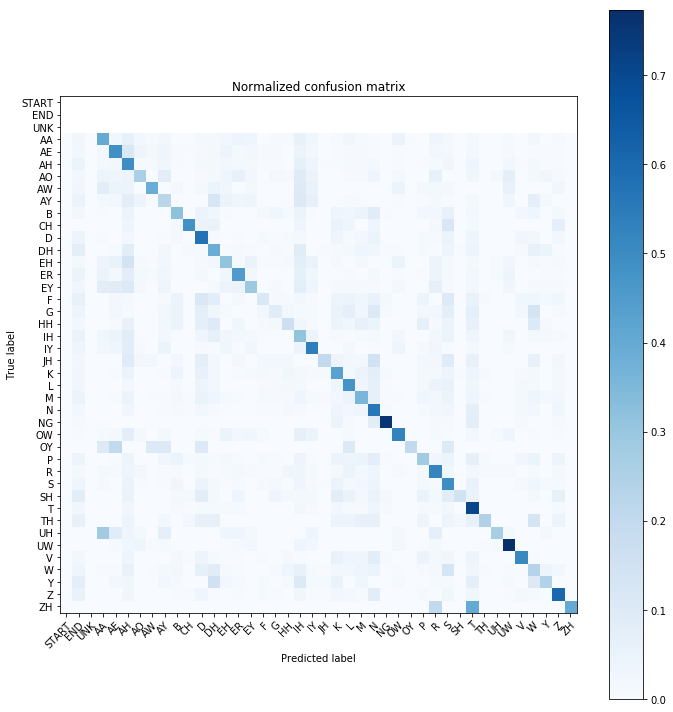

In [53]:
plot_confusion_matrix(cf_mat, phoneme_re_list,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

In [38]:
print(np.sum(np.equal(flattened_test_gt, 40)))

285


In [42]:
print(cf_mat.shape)

(42, 42)
